# TODO:
- trzeba się zastanowić jakie zakres hyper parametrów bierzemy - ADAM -TODO
- sprawdić jak zmiana seed w random search wpływa na wyniki tunowalnośći (sampling bias) - TODO (zmienaimy seed i patrzymy czy tunowalność się zmienia -> tabelka z 10 seedami i patrzyma jak zmienia się tunowalnosć) -TODO ( przy pisaniu raportu)

### Imports

In [1]:
import itertools
import random
from typing import List, Tuple

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from pandas import DataFrame, Series
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import ElasticNet
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor
from skopt.space import Integer, Real

from utills.best_config_bayes import (
    find_best_config_using_bayes,
    find_best_configs_in_search_space_with_bayes,
)
from utills.best_config_random_search import (
    find_best_configs_in_search_space_with_random_search,
)
from utills.dataset import load_dataset_from_id, split_dataset
from utills.dump_data import (
    dump_optimal_config_search_history,
    dump_scores_to_csv,
    dump_tunability_to_csv,
)
from utills.optimal_config import find_optimal_configuration_for_all_datasets
from utills.pipeline import get_column_transformer
from utills.tunability import (
    calculate_aggregate_tunability,
    calculate_tunability_on_each_dataset,
)

# Constants

In [2]:
NUM_ITER_BAYES = 50
NUM_POINTS_RS_DECISION_TREE = 50
NUM_POINTS_RS_ELASTIC_NET = 50
NUM_POINTS_RS_RANDOM_FOREST = 50
SEED = 321

### Utill functions

### Load datasets

In [3]:
fish_market_dataset_id = (
    43308  # https://www.openml.org/search?type=data&id=43308&sort=runs&status=active
)
cars_dataset_id = (
    44994  # https://www.openml.org/search?type=data&status=active&id=44994
)
diabetes_dataset_id = (
    44223  # https://www.openml.org/search?type=data&id=44223&sort=runs&status=active
)

lisbona_house_prices_dataset_id = (
    43660  # https://www.openml.org/search?type=data&id=43660&sort=runs&status=active
)

rmftsa_ladata_dataset_id = (
    666  # https://www.openml.org/search?type=data&status=active&id=666
)
boston_dataset_id = 531  # https://www.openml.org/search?type=data&status=active&id=531

treasury_dataset_id = (
    42367  # https://www.openml.org/search?type=data&status=active&id=42367
)

bank32nh_dataset_id = (
    558  # https://www.openml.org/search?type=data&status=active&id=558
)

puma32H_dataset_id = 308  # https://www.openml.org/search?type=data&status=active&id=308

fish_market_dataset: DataFrame = load_dataset_from_id(id=fish_market_dataset_id)
fish_market_regression_class = "Weight"

cars_dataset: DataFrame = load_dataset_from_id(id=cars_dataset_id)
cars_regression_class = "Price"

diabetes_dataset: DataFrame = load_dataset_from_id(id=diabetes_dataset_id)
diabetes_regression_class = "class"

lisbona_house_prices_dataset: DataFrame = load_dataset_from_id(
    id=lisbona_house_prices_dataset_id
)
lisbona_house_prices_regression_class = "Price"

rmftsa_ladata_dataset = load_dataset_from_id(id=rmftsa_ladata_dataset_id)
rmftsa_ladata_regression_class = "Respiratory_Mortality"

boston_dataset = load_dataset_from_id(id=boston_dataset_id)
boston_regression_class = "MEDV"

treasury_dataset = load_dataset_from_id(id=treasury_dataset_id)
treasury_regression_class = "1MonthCDRate"

bank32nh_dataset = load_dataset_from_id(id=bank32nh_dataset_id)
bank32nh_regression_class = "rej"

puma32H_dataset = load_dataset_from_id(id=puma32H_dataset_id)
puma32H_regression_class = "thetadd6"

c:\JAN_CICHOMSKI\STUDIA\STUDIA_SEMESTR_7_2023_ZIMA\auto_ml\homeworks\homework_1\AutoML_HM1\.venv\lib\site-packages\openml\datasets\functions.py:438: FutureWarning: Starting from Version 0.15 `download_data`, `download_qualities`, and `download_features_meta_data` will all be ``False`` instead of ``True`` by default to enable lazy loading. To disable this message until version 0.15 explicitly set `download_data`, `download_qualities`, and `download_features_meta_data` to a bool while calling `get_dataset`.
  warnings.warn(
c:\JAN_CICHOMSKI\STUDIA\STUDIA_SEMESTR_7_2023_ZIMA\auto_ml\homeworks\homework_1\AutoML_HM1\.venv\lib\site-packages\openml\datasets\functions.py:438: FutureWarning: Starting from Version 0.15 `download_data`, `download_qualities`, and `download_features_meta_data` will all be ``False`` instead of ``True`` by default to enable lazy loading. To disable this message until version 0.15 explicitly set `download_data`, `download_qualities`, and `download_features_meta_data` 

### Split data into train and test sets

In [4]:
(
    X_train_fish_market,
    X_test_fish_market,
    y_train_fish_market,
    y_test_fish_market,
) = split_dataset(data=fish_market_dataset, class_=fish_market_regression_class)

(
    X_train_cars,
    X_test_cars,
    y_train_cars,
    y_test_cars,
) = split_dataset(data=cars_dataset, class_=cars_regression_class)

X_train_diabetes, X_test_diabetes, y_train_diabetes, y_test_diabetes = split_dataset(
    diabetes_dataset, diabetes_regression_class
)

(
    X_train_lisbona_house_prices,
    X_test_lisbona_house_prices,
    y_train_lisbona_house_prices,
    y_test_lisbona_house_prices,
) = split_dataset(lisbona_house_prices_dataset, lisbona_house_prices_regression_class)

(
    X_train_rmftsa_ladata,
    X_test_rmftsa_ladata,
    y_train_rmftsa_ladata,
    y_test_rmftsa_ladata,
) = split_dataset(rmftsa_ladata_dataset, rmftsa_ladata_regression_class)

X_train_boston, X_test_boston, y_train_boston, y_test_boston = split_dataset(
    boston_dataset, boston_regression_class
)

X_train_treasury, X_test_treasury, y_train_treasury, y_test_treasury = split_dataset(
    treasury_dataset, treasury_regression_class
)

X_train_bank32nh, X_test_bank32nh, y_train_bank32nh, y_test_bank32nh = split_dataset(
    bank32nh_dataset, bank32nh_regression_class
)

X_train_puma32H, X_test_puma32H, y_train_puma32H, y_test_puma32H = split_dataset(
    puma32H_dataset, puma32H_regression_class
)

In [5]:
def get_train_datasets() -> List[Tuple[DataFrame, Series]]:
    return [
        (X_train_fish_market, y_train_fish_market),
        (X_train_cars, y_train_cars),
        (X_train_diabetes, y_train_diabetes),
        (X_train_lisbona_house_prices, y_train_lisbona_house_prices),
        (X_train_rmftsa_ladata, y_train_rmftsa_ladata),
        (X_train_boston, y_train_boston),
        (X_train_treasury, y_train_treasury),
    ]

In [6]:
def get_test_datasets():
    return [
        (X_test_fish_market, y_test_fish_market),
        (X_test_cars, y_test_cars),
        (X_test_diabetes, y_test_diabetes),
        (X_test_lisbona_house_prices, y_test_lisbona_house_prices),
        (X_test_rmftsa_ladata, y_test_rmftsa_ladata),
        (X_test_boston, y_test_boston),
        (X_test_treasury, y_test_treasury),
    ]


# 1. Decision Tree

## Prepare model and search space

In [7]:
def get_decision_tree_pipeline() -> Pipeline:
    decision_tree = DecisionTreeRegressor(random_state=SEED)
    col_trans: ColumnTransformer = get_column_transformer()
    decision_tree_pipeline = Pipeline(
        steps=[("column_transformer", col_trans), ("model", decision_tree)]
    )
    return decision_tree_pipeline

In [8]:
def get_parameter_grid_decision_tree():
    # parameters space
    random.seed(SEED)
    ccp_alpha_values = [i * 0.1 for i in range(11)]

    max_depth_values = range(1, 31, 1)

    min_samples_split_values = range(2, 61, 1)

    min_samples_leaf_values = range(1, 61, 1)

    all_combinations = list(
        itertools.product(
            ccp_alpha_values,
            max_depth_values,
            min_samples_split_values,
            min_samples_leaf_values,
        )
    )

    selected_combinations: List[Tuple[float, int, int, int]] = random.sample(
        all_combinations, NUM_POINTS_RS_DECISION_TREE
    )

    parameter_names = [
        "model__ccp_alpha",
        "model__max_depth",
        "model__min_samples_split",
        "model__min_samples_leaf",
    ]

    config_grid = [
        dict(zip(parameter_names, combination)) for combination in selected_combinations
    ]

    return config_grid

## Find optimal default hyperparameters 

In [9]:
# find teta*

(
    optimal_config_decision_tree,
    best_summary_score_decision_tree,
    history_scores,
) = find_optimal_configuration_for_all_datasets(
    config_space=get_parameter_grid_decision_tree(),
    train_datasets=get_train_datasets(),
    test_datasets=get_test_datasets(),
    get_model=get_decision_tree_pipeline,
    summary_func=np.mean,  # Or np.median for a more robust approach
)
dump_optimal_config_search_history(
    history_scores, "output_data/decision_tree/optimal_config_search_history.csv"
)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


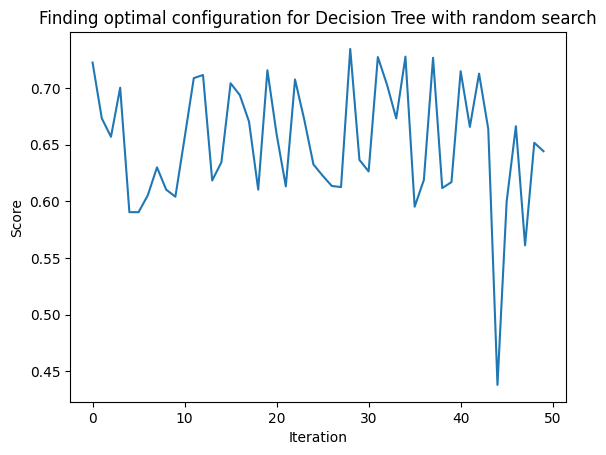

In [10]:
plt.plot(history_scores)
plt.xlabel("Iteration")
plt.ylabel("Score")
plt.title("Finding optimal configuration for Decision Tree with random search")
plt.show()

In [11]:
print(optimal_config_decision_tree)
print(best_summary_score_decision_tree)

{'model__ccp_alpha': 0.4, 'model__max_depth': 30, 'model__min_samples_split': 10, 'model__min_samples_leaf': 4}
0.7346105212364898


## Evaluate model with optimal hyperparameters on each dataset

In [12]:
for train_dataset, test_dataset in zip(get_train_datasets(), get_test_datasets()):
    optimal_model: Pipeline = get_decision_tree_pipeline()
    optimal_model.set_params(**optimal_config_decision_tree)
    optimal_model.fit(train_dataset[0], train_dataset[1])
    score = optimal_model.score(test_dataset[0], test_dataset[1])
    print("Optimal decision tree score on dataset : " + str(score))

Optimal decision tree score on dataset : 0.9664413135011902
Optimal decision tree score on dataset : 0.9427984728841297
Optimal decision tree score on dataset : 0.2444610870167533
Optimal decision tree score on dataset : 0.6855445309253174
Optimal decision tree score on dataset : 0.5694226766895747
Optimal decision tree score on dataset : 0.852955406395201
Optimal decision tree score on dataset : 0.8806501612432637


## Find best hyperparameters for given dataset with random search

In [13]:
# find tate^(j)*
(
    best_decision_tree_configs_for_each_dataset,
    list_iteration_scores,
) = find_best_configs_in_search_space_with_random_search(
    get_pipeline=get_decision_tree_pipeline,
    config_space=get_parameter_grid_decision_tree(),
    train_datasets=get_train_datasets(),
    test_datasets=get_test_datasets(),
)
for i, iteration_scores in enumerate(list_iteration_scores):
    dump_scores_to_csv(
        iteration_scores,
        f"output_data/decision_tree/random_search_iteration_scores_dataset_{i}.csv",
    )

dataset: 0
score: 0.9664413135011902
best config: {'model__ccp_alpha': 0.4, 'model__max_depth': 30, 'model__min_samples_split': 10, 'model__min_samples_leaf': 4}
dataset: 1
score: 0.9427984728841297
best config: {'model__ccp_alpha': 0.4, 'model__max_depth': 30, 'model__min_samples_split': 10, 'model__min_samples_leaf': 4}
dataset: 2
score: 0.4843544089451588
best config: {'model__ccp_alpha': 0.2, 'model__max_depth': 5, 'model__min_samples_split': 52, 'model__min_samples_leaf': 11}
dataset: 3
score: 0.6870987798830219
best config: {'model__ccp_alpha': 0.5, 'model__max_depth': 14, 'model__min_samples_split': 13, 'model__min_samples_leaf': 1}
dataset: 4
score: 0.5694226766895747
best config: {'model__ccp_alpha': 0.4, 'model__max_depth': 30, 'model__min_samples_split': 10, 'model__min_samples_leaf': 4}
dataset: 5
score: 0.8633783470182926
best config: {'model__ccp_alpha': 0.4, 'model__max_depth': 22, 'model__min_samples_split': 32, 'model__min_samples_leaf': 2}
dataset: 6
score: 0.97398859

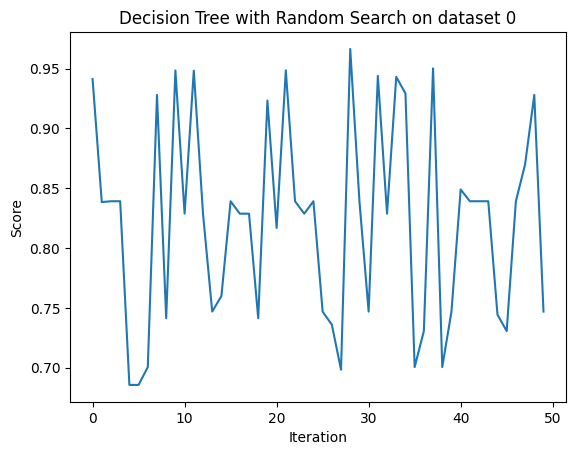

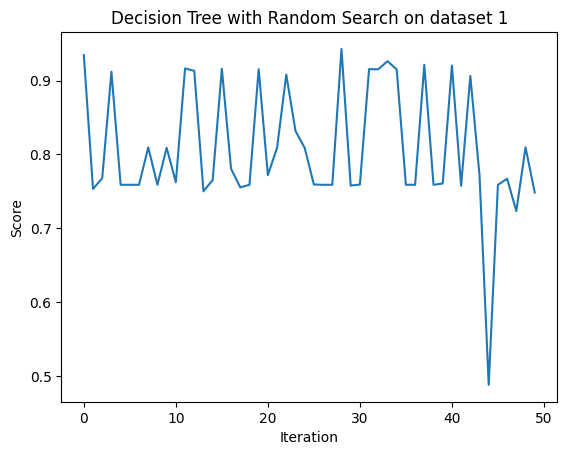

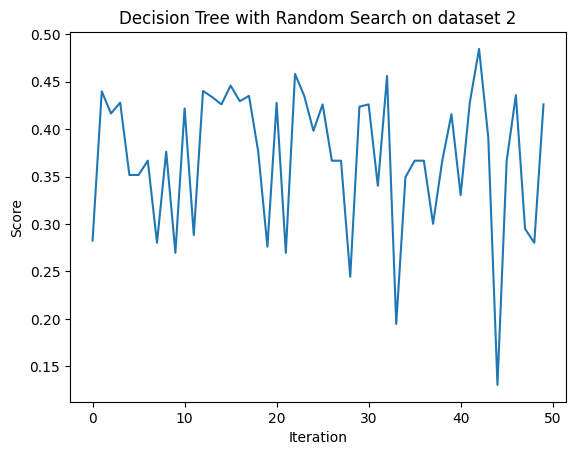

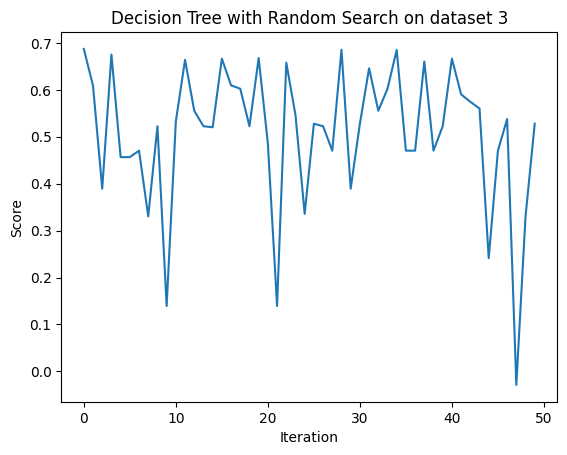

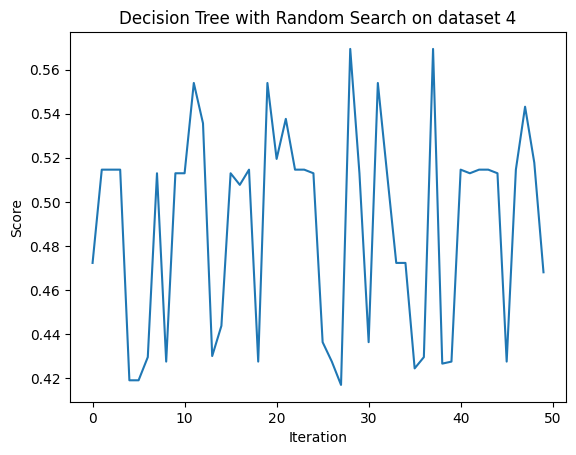

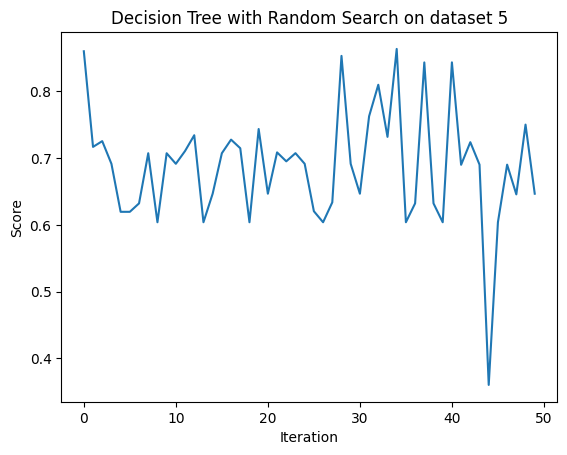

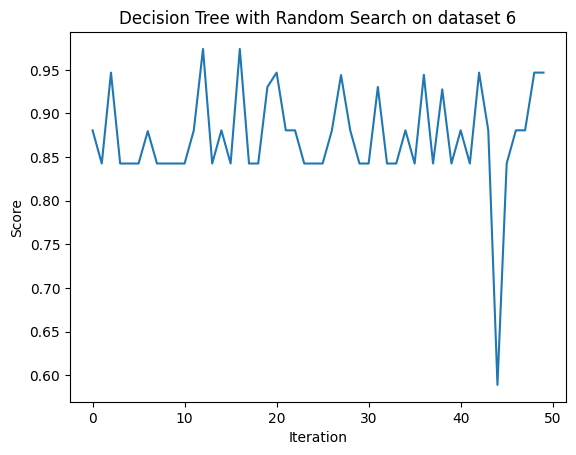

In [14]:
for i, iteration_scores in enumerate(list_iteration_scores):
    plt.plot(iteration_scores)
    plt.xlabel("Iteration")
    plt.ylabel("Score")
    plt.title(f"Decision Tree with Random Search on dataset {i}")
    plt.show()

## Calculate tunability on each dataset

In [15]:
# find d^j
tunability_per_dataset = calculate_tunability_on_each_dataset(
    train_datasets=get_train_datasets(),
    test_datasets=get_test_datasets(),
    best_configs=best_decision_tree_configs_for_each_dataset,
    optimal_config=optimal_config_decision_tree,
    get_model_pipeline=get_decision_tree_pipeline,
)
dump_tunability_to_csv(
    tunability_per_dataset=tunability_per_dataset,
    filepath="output_data/decision_tree/random_search_tunability.csv",
)

d^j: 0.9664413135011902 - 0.9664413135011902 = 0.0
d^j: 0.9427984728841297 - 0.9427984728841297 = 0.0
d^j: 0.2444610870167533 - 0.4843544089451588 = -0.2398933219284055
d^j: 0.6855445309253174 - 0.6870987798830219 = -0.001554248957704507
d^j: 0.5694226766895747 - 0.5694226766895747 = 0.0
d^j: 0.852955406395201 - 0.8633783470182926 = -0.010422940623091681
d^j: 0.8806501612432637 - 0.9739885910805848 = -0.0933384298373211


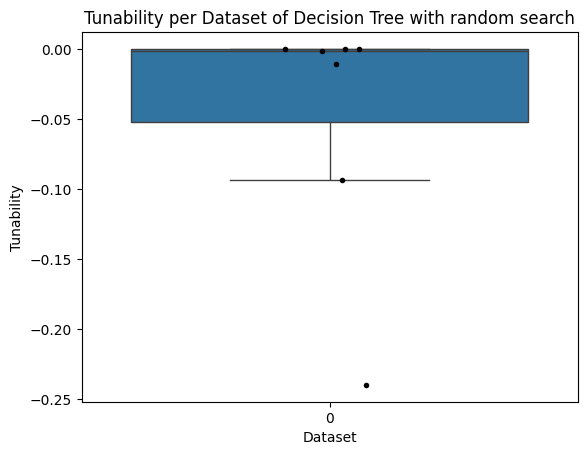

In [16]:
tunability_data = [tunability_per_dataset]

sns.boxplot(data=tunability_data, showfliers=False)

# add strip plot
sns.stripplot(data=tunability_data, color="black", size=4)

# add labels and title
plt.xlabel("Dataset")
plt.ylabel("Tunability")
plt.title("Tunability per Dataset of Decision Tree with random search")

# show the plot
plt.show()

In [17]:
# aggregated tunability d
print(
    "Aggregated tunability d: "
    + str(calculate_aggregate_tunability(tunability_per_dataset))
)

Aggregated tunability d: -0.049315563049503255


## Find best hyperparameters for given dataset with bayesian search

In [18]:
def get_bayes_search_space_decision_tree():
    return (
        {
            "model__ccp_alpha": Real(0.0, 1.0),
            "model__max_depth": Integer(1, 30),
            "model__min_samples_split": Integer(2, 60),
            "model__min_samples_leaf": Integer(1, 60),
        },
        NUM_ITER_BAYES,
    )

In [19]:
np.int = np.int64  # hack so numpy doesn't complain about missing np.int :)
# calculate all configs
(
    best_configs_for_decision_tree,
    histories,
) = find_best_configs_in_search_space_with_bayes(
    search_space=get_bayes_search_space_decision_tree(),
    get_pipeline=get_decision_tree_pipeline,
    train_datasets=get_train_datasets(),
)
for i, history in enumerate(histories):
    dump_scores_to_csv(
        history, f"output_data/decision_tree/bayes_iteration_scores_dataset_{i}.csv"
    )

c:\JAN_CICHOMSKI\STUDIA\STUDIA_SEMESTR_7_2023_ZIMA\auto_ml\homeworks\homework_1\AutoML_HM1\.venv\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration 1: Score = 0.6227862928195934
Iteration 2: Score = 0.8183606072184088
Iteration 3: Score = 0.6166370611377376
Iteration 4: Score = 0.7819467475731763
Iteration 5: Score = 0.7909202490869405
Iteration 6: Score = 0.7378711368909865
Iteration 7: Score = 0.6258598490743615
Iteration 8: Score = 0.6310443819100943
Iteration 9: Score = 0.29074506162787994
Iteration 10: Score = 0.8792691016984306
Iteration 11: Score = 0.9644064262154582
Iteration 12: Score = 0.7819467475731763
Iteration 13: Score = 0.6938644238320535
Iteration 14: Score = 0.9644064262154582
Iteration 15: Score = 0.7923985560190046
Iteration 16: Score = 0.9725700309253631
Iteration 17: Score = 0.931818644205604
Iteration 18: Score = 0.9701239401461702
Iteration 19: Score = -0.05320919309927987
Iteration 20: Score = 0.9644759138462007
Iteration 21: Score = 0.6938644238320535
Iteration 22: Score = 0.929594716522492
Iteration 23: Score = 0.7805398305254894
Iteration 24: Score = 0.6938644238320535
Iteration 25: Score = 0.

c:\JAN_CICHOMSKI\STUDIA\STUDIA_SEMESTR_7_2023_ZIMA\auto_ml\homeworks\homework_1\AutoML_HM1\.venv\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\JAN_CICHOMSKI\STUDIA\STUDIA_SEMESTR_7_2023_ZIMA\auto_ml\homeworks\homework_1\AutoML_HM1\.venv\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration 1: Score = 0.740978854171329
Iteration 2: Score = 0.7744837955320608
Iteration 3: Score = 0.7464731418259455
Iteration 4: Score = 0.7804312673338515
Iteration 5: Score = 0.7884585045167304
Iteration 6: Score = 0.745693334006759
Iteration 7: Score = 0.4027899856735796
Iteration 8: Score = 0.7327489049701492
Iteration 9: Score = 0.7389303472026743
Iteration 10: Score = 0.8588356694766114
Iteration 11: Score = 0.9135048325892863
Iteration 12: Score = 0.9091031552765925
Iteration 13: Score = 0.8104132638705858
Iteration 14: Score = 0.4027899856735796
Iteration 15: Score = 0.9111896980034964
Iteration 16: Score = 0.6843672010227231
Iteration 17: Score = 0.4027899856735796
Iteration 18: Score = 0.9098782024019499
Iteration 19: Score = 0.7464761399768547
Iteration 20: Score = 0.7573338202582237
Iteration 21: Score = 0.9102236927289244
Iteration 22: Score = 0.9091042815878868
Iteration 23: Score = 0.6843672010227231
Iteration 24: Score = 0.9091031552765925
Iteration 25: Score = 0.909

c:\JAN_CICHOMSKI\STUDIA\STUDIA_SEMESTR_7_2023_ZIMA\auto_ml\homeworks\homework_1\AutoML_HM1\.venv\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration 1: Score = 0.48545524884879115
Iteration 2: Score = 0.6056822834385329
Iteration 3: Score = 0.45545144623014194
Iteration 4: Score = 0.5561965373240213
Iteration 5: Score = 0.5803254658913239
Iteration 6: Score = 0.4848049395156829
Iteration 7: Score = 0.41394011945668574
Iteration 8: Score = 0.4812910872590111
Iteration 9: Score = 0.4535436531911349
Iteration 10: Score = 0.6785380077586121
Iteration 11: Score = 0.6457760534925703
Iteration 12: Score = 0.5351226394991274
Iteration 13: Score = 0.3591708745433257
Iteration 14: Score = 0.5685746064006537
Iteration 15: Score = 0.7239474626240932
Iteration 16: Score = 0.3591708745433257
Iteration 17: Score = 0.6998597304172709
Iteration 18: Score = 0.6053877511055917
Iteration 19: Score = 0.719224749171617
Iteration 20: Score = 0.3591708745433257
Iteration 21: Score = 0.6081007486258667
Iteration 22: Score = 0.6270158786778041
Iteration 23: Score = 0.6692820817067927
Iteration 24: Score = 0.4575503823427976
Iteration 25: Score = 0

### Plot bayes optimization history for each dataset

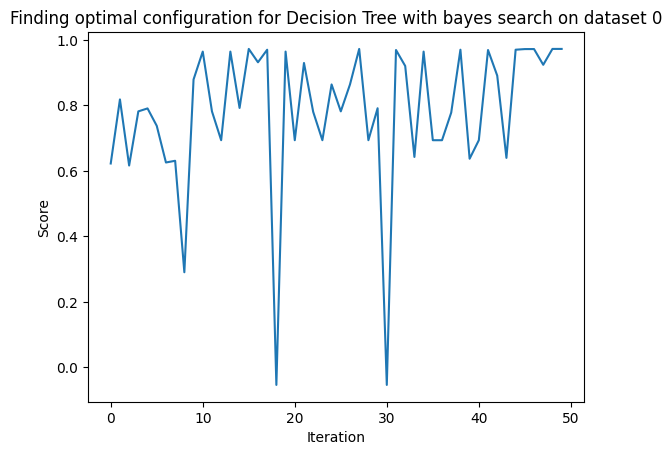

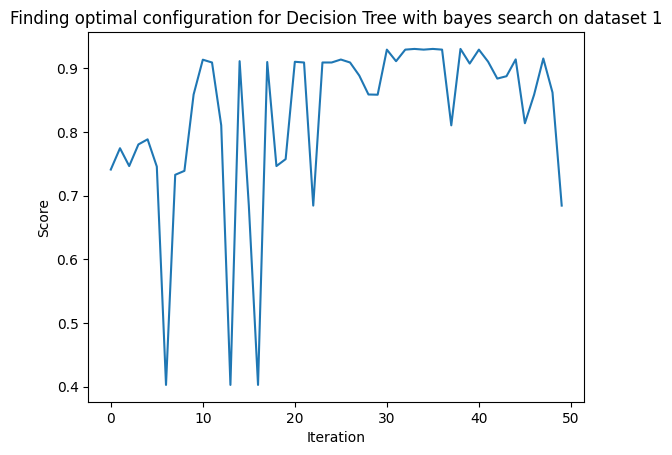

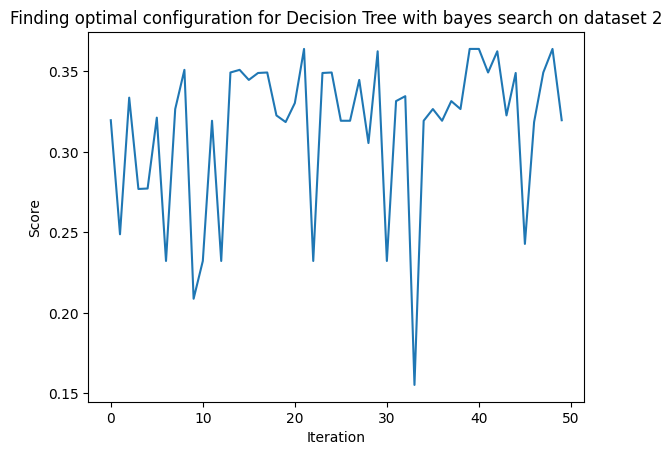

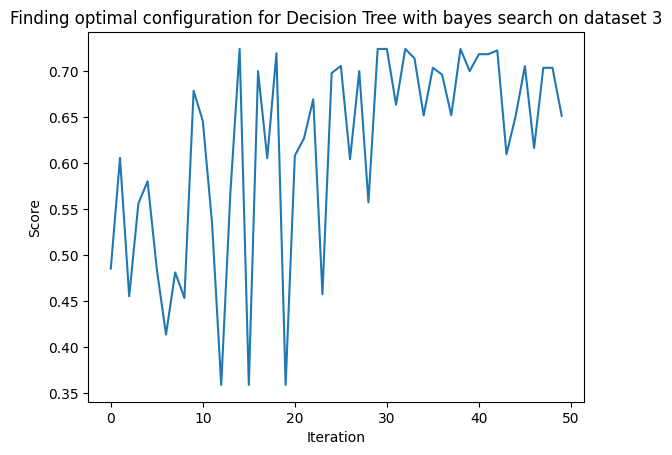

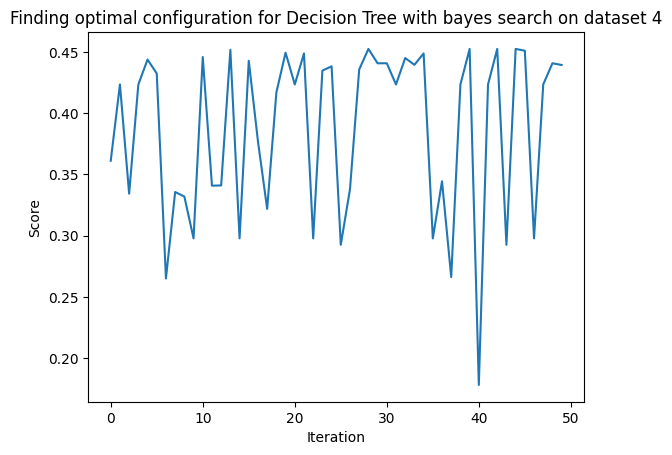

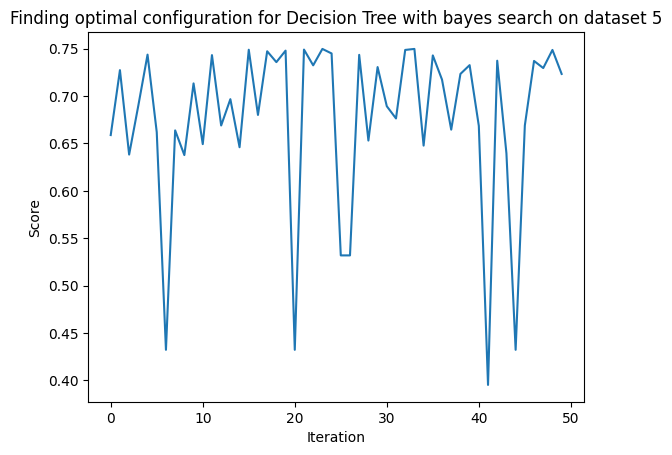

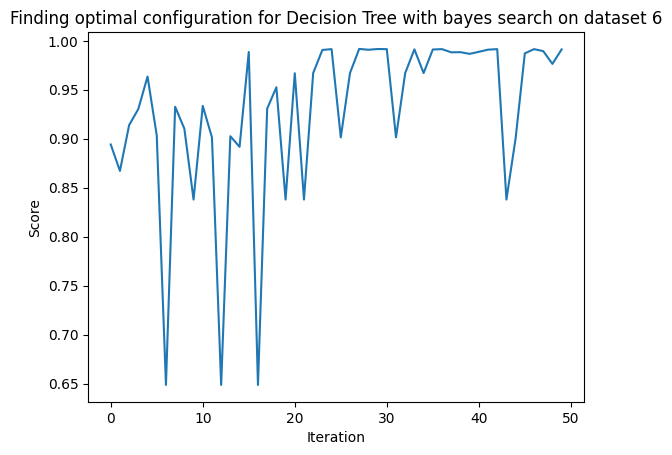

In [20]:
for i in range(len(histories)):
    plt.plot(histories[i])
    plt.xlabel("Iteration")
    plt.ylabel("Score")
    plt.title(
        f"Finding optimal configuration for Decision Tree with bayes search on dataset {i}"
    )
    plt.show()

## Calculate tunability on each dataset

In [21]:
tunability_per_dataset = calculate_tunability_on_each_dataset(
    train_datasets=get_train_datasets(),
    test_datasets=get_test_datasets(),
    best_configs=best_configs_for_decision_tree,
    optimal_config=optimal_config_decision_tree,
    get_model_pipeline=get_decision_tree_pipeline,
)
dump_tunability_to_csv(
    tunability_per_dataset=tunability_per_dataset,
    filepath="output_data/decision_tree/bayes_tunability.csv",
)

d^j: 0.9664413135011902 - 0.9497769413293313 = 0.0166643721718589
d^j: 0.9427984728841297 - 0.9392885451098791 = 0.003509927774250521
d^j: 0.2444610870167533 - 0.3666575524702239 = -0.12219646545347063
d^j: 0.6855445309253174 - 0.5846261238457404 = 0.100918407079577
d^j: 0.5694226766895747 - 0.5146097729675974 = 0.054812903721977335
d^j: 0.852955406395201 - 0.7459690921417612 = 0.10698631425343974
d^j: 0.8806501612432637 - 0.9891131554750265 = -0.10846299423176287


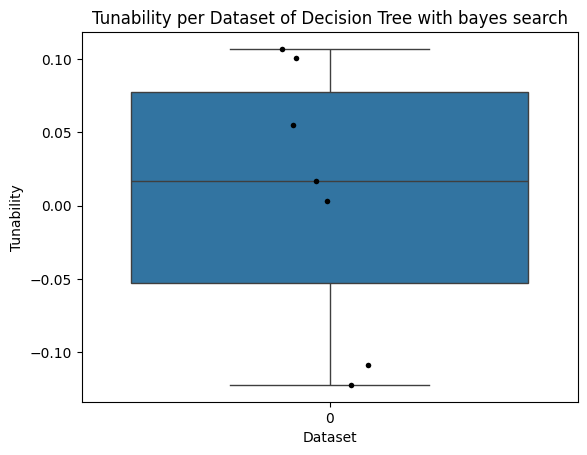

In [22]:
tunability_data = [tunability_per_dataset]

sns.boxplot(data=tunability_data, showfliers=False)

# add strip plot
sns.stripplot(data=tunability_data, color="black", size=4)

# add labels and title
plt.xlabel("Dataset")
plt.ylabel("Tunability")
plt.title("Tunability per Dataset of Decision Tree with bayes search")

# show the plot
plt.show()

In [23]:
# aggregated tunability d
print(
    "Aggregated tunability d: "
    + str(calculate_aggregate_tunability(tunability_per_dataset))
)

Aggregated tunability d: 0.0074617807594100005


# 2. ElasticNet

## Prepare model and search space

In [24]:
def get_elasticnet_pipeline() -> Pipeline:
    elastic_net = ElasticNet(max_iter=10000, random_state=SEED)
    col_trans: ColumnTransformer = get_column_transformer()
    decision_tree_pipeline = Pipeline(
        steps=[("column_transformer", col_trans), ("model", elastic_net)]
    )
    return decision_tree_pipeline

In [25]:
def get_parameter_grid_for_elasticnet():
    # parameters space
    random.seed(SEED)
    alpha = [2**i for i in range(-10, 11, 1)]
    l1_ratio = [i * 0.05 for i in range(21)]
    all_combinations = list(
        itertools.product(
            alpha,
            l1_ratio,
        )
    )
    selected_combinations: List[Tuple[float, int, int, int]] = random.sample(
        all_combinations, NUM_POINTS_RS_ELASTIC_NET
    )
    parameter_names = [
        "model__alpha",
        "model__l1_ratio",
    ]

    parameters_grid_elasticnet = [
        dict(zip(parameter_names, combination)) for combination in selected_combinations
    ]
    return parameters_grid_elasticnet

## Find optimal default hyperparameters 

In [26]:
# find teta*

(
    optimal_config_elasticnet,
    best_summary_score_elasticnet,
    history_scores,
) = find_optimal_configuration_for_all_datasets(
    config_space=get_parameter_grid_for_elasticnet(),
    train_datasets=get_train_datasets(),
    test_datasets=get_test_datasets(),
    get_model=get_elasticnet_pipeline,
    summary_func=np.mean,  # Or np.median for a more robust approach
)
dump_optimal_config_search_history(
    history_scores, "output_data/elasticnet/optimal_config_search_history.csv"
)

0
1
2
3
4
5
6
7
8


c:\JAN_CICHOMSKI\STUDIA\STUDIA_SEMESTR_7_2023_ZIMA\auto_ml\homeworks\homework_1\AutoML_HM1\.venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.662e+08, tolerance: 5.962e+06
  model = cd_fast.enet_coordinate_descent(
c:\JAN_CICHOMSKI\STUDIA\STUDIA_SEMESTR_7_2023_ZIMA\auto_ml\homeworks\homework_1\AutoML_HM1\.venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.860e+11, tolerance: 4.005e+09
  model = cd_fast.enet_coordinate_descent(


9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


c:\JAN_CICHOMSKI\STUDIA\STUDIA_SEMESTR_7_2023_ZIMA\auto_ml\homeworks\homework_1\AutoML_HM1\.venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.652e+06, tolerance: 1.561e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
c:\JAN_CICHOMSKI\STUDIA\STUDIA_SEMESTR_7_2023_ZIMA\auto_ml\homeworks\homework_1\AutoML_HM1\.venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.207e+10, tolerance: 5.962e+06 Linear reg

30
31
32
33
34
35


c:\JAN_CICHOMSKI\STUDIA\STUDIA_SEMESTR_7_2023_ZIMA\auto_ml\homeworks\homework_1\AutoML_HM1\.venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.512e+09, tolerance: 4.005e+09
  model = cd_fast.enet_coordinate_descent(


36
37
38
39
40
41
42
43
44
45
46
47
48
49


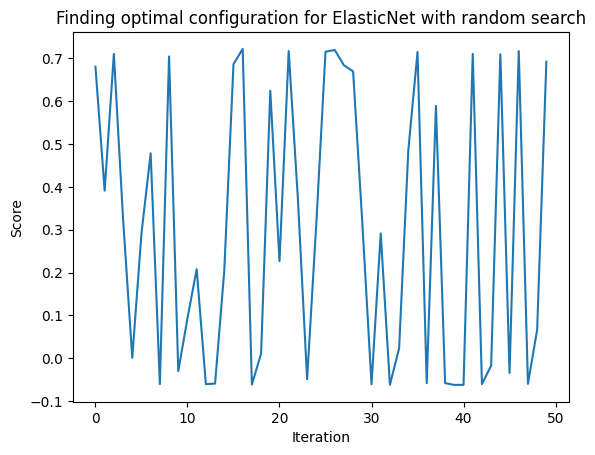

In [27]:
plt.plot(history_scores)
plt.xlabel("Iteration")
plt.ylabel("Score")
plt.title("Finding optimal configuration for ElasticNet with random search")
plt.show()

In [28]:
print(optimal_config_elasticnet)
print(best_summary_score_elasticnet)

{'model__alpha': 0.0009765625, 'model__l1_ratio': 0.35000000000000003}
0.7221840452963396


## Evaluate model with optimal hyperparameters on each dataset

In [29]:
for train_dataset, test_dataset in zip(get_train_datasets(), get_test_datasets()):
    optimal_model: Pipeline = get_elasticnet_pipeline()
    optimal_model.set_params(**optimal_config_elasticnet)
    optimal_model.fit(train_dataset[0], train_dataset[1])
    score = optimal_model.score(test_dataset[0], test_dataset[1])
    print("Optimal elasticnet score on dataset : " + str(score))

Optimal elasticnet score on dataset : 0.9493198373500374
Optimal elasticnet score on dataset : 0.9234301066751305
Optimal elasticnet score on dataset : 0.4562601389486769
Optimal elasticnet score on dataset : 0.5380720957277267
Optimal elasticnet score on dataset : 0.5601648526717664
Optimal elasticnet score on dataset : 0.6359803184465578
Optimal elasticnet score on dataset : 0.992060967254481


## Find best hyperparameters for given dataset with random search

In [30]:
# find tate^(j)*
(
    best_elasticnet_configs_for_each_dataset,
    list_iteration_scores,
) = find_best_configs_in_search_space_with_random_search(
    get_pipeline=get_elasticnet_pipeline,
    config_space=get_parameter_grid_for_elasticnet(),
    train_datasets=get_train_datasets(),
    test_datasets=get_test_datasets(),
)
for i, iteration_scores in enumerate(list_iteration_scores):
    dump_scores_to_csv(
        iteration_scores,
        f"output_data/elasticnet/random_search_iteration_scores_dataset_{i}.csv",
    )

c:\JAN_CICHOMSKI\STUDIA\STUDIA_SEMESTR_7_2023_ZIMA\auto_ml\homeworks\homework_1\AutoML_HM1\.venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.652e+06, tolerance: 1.561e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


dataset: 0
score: 0.9493198373500374
best config: {'model__alpha': 0.0009765625, 'model__l1_ratio': 0.35000000000000003}


c:\JAN_CICHOMSKI\STUDIA\STUDIA_SEMESTR_7_2023_ZIMA\auto_ml\homeworks\homework_1\AutoML_HM1\.venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.662e+08, tolerance: 5.962e+06
  model = cd_fast.enet_coordinate_descent(
c:\JAN_CICHOMSKI\STUDIA\STUDIA_SEMESTR_7_2023_ZIMA\auto_ml\homeworks\homework_1\AutoML_HM1\.venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.207e+10, tolerance: 5.962e+06 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = 

dataset: 1
score: 0.9239271647899755
best config: {'model__alpha': 0.03125, 'model__l1_ratio': 1.0}


c:\JAN_CICHOMSKI\STUDIA\STUDIA_SEMESTR_7_2023_ZIMA\auto_ml\homeworks\homework_1\AutoML_HM1\.venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.860e+05, tolerance: 2.145e+02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


dataset: 2
score: 0.461635948054153
best config: {'model__alpha': 0.0625, 'model__l1_ratio': 0.8500000000000001}


c:\JAN_CICHOMSKI\STUDIA\STUDIA_SEMESTR_7_2023_ZIMA\auto_ml\homeworks\homework_1\AutoML_HM1\.venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.860e+11, tolerance: 4.005e+09
  model = cd_fast.enet_coordinate_descent(
c:\JAN_CICHOMSKI\STUDIA\STUDIA_SEMESTR_7_2023_ZIMA\auto_ml\homeworks\homework_1\AutoML_HM1\.venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.695e+13, tolerance: 4.005e+09 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = 

dataset: 3
score: 0.5461621610048648
best config: {'model__alpha': 0.00390625, 'model__l1_ratio': 0.1}


c:\JAN_CICHOMSKI\STUDIA\STUDIA_SEMESTR_7_2023_ZIMA\auto_ml\homeworks\homework_1\AutoML_HM1\.venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.472e+03, tolerance: 3.145e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


dataset: 4
score: 0.5636432956877125
best config: {'model__alpha': 0.0009765625, 'model__l1_ratio': 0.8}


c:\JAN_CICHOMSKI\STUDIA\STUDIA_SEMESTR_7_2023_ZIMA\auto_ml\homeworks\homework_1\AutoML_HM1\.venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.490e+04, tolerance: 3.510e+00 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


dataset: 5
score: 0.6560278770400093
best config: {'model__alpha': 0.0078125, 'model__l1_ratio': 0.05}


c:\JAN_CICHOMSKI\STUDIA\STUDIA_SEMESTR_7_2023_ZIMA\auto_ml\homeworks\homework_1\AutoML_HM1\.venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.362e+03, tolerance: 9.548e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


dataset: 6
score: 0.9926934600160636
best config: {'model__alpha': 0.0009765625, 'model__l1_ratio': 0.8}


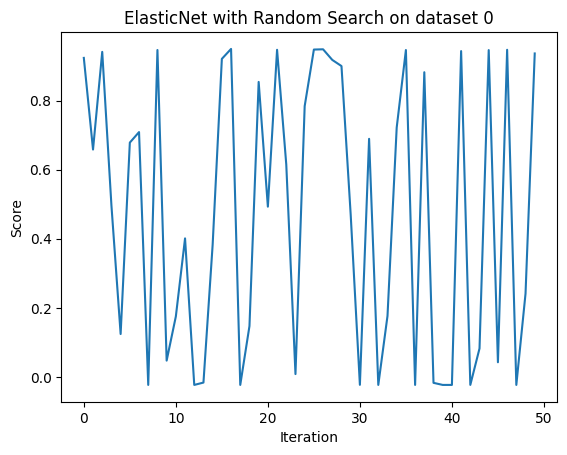

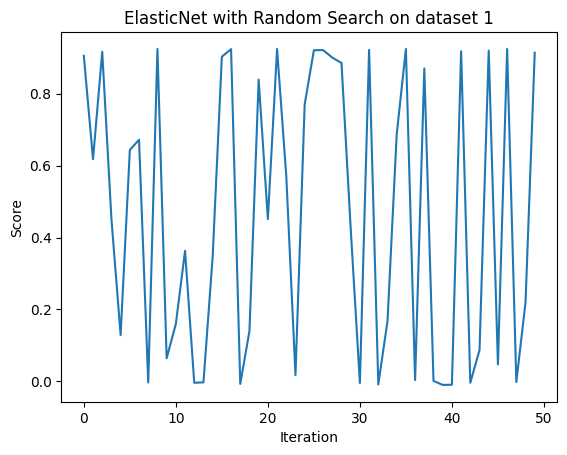

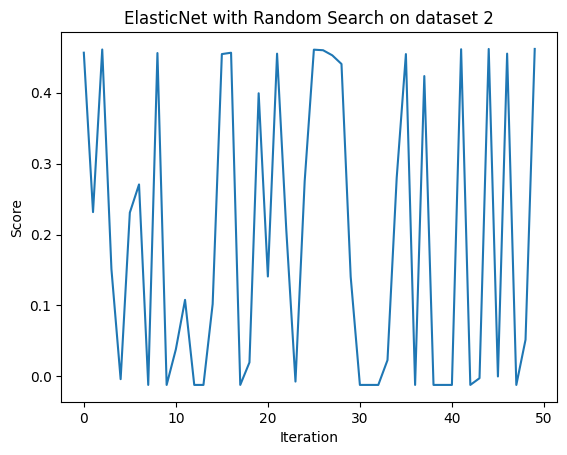

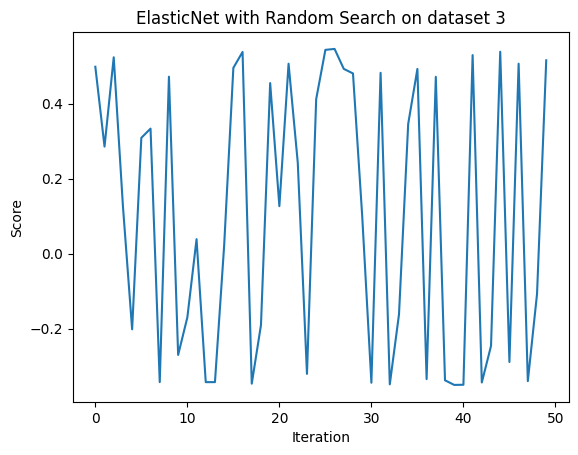

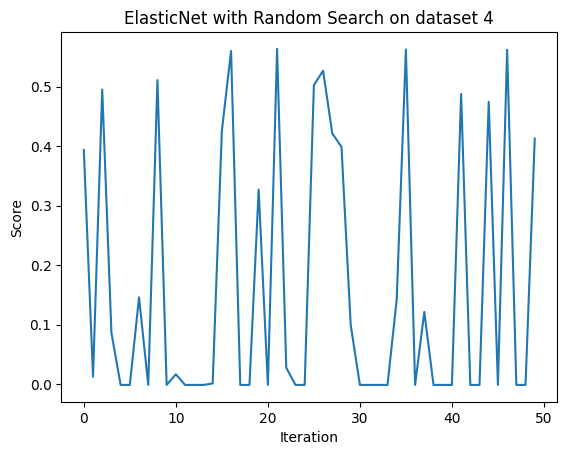

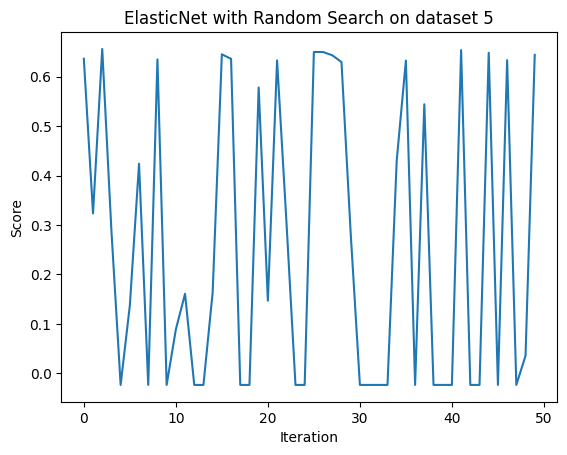

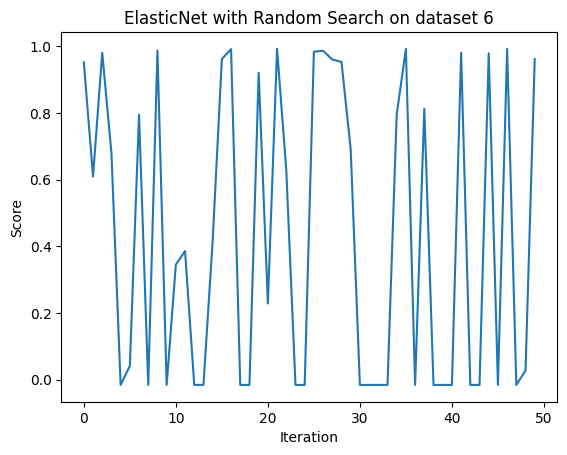

In [31]:
for i, iteration_scores in enumerate(list_iteration_scores):
    plt.plot(iteration_scores)
    plt.xlabel("Iteration")
    plt.ylabel("Score")
    plt.title(f"ElasticNet with Random Search on dataset {i}")
    plt.show()

## Calculate tunability on each dataset

In [32]:
# find d^j

tunability_per_dataset = calculate_tunability_on_each_dataset(
    train_datasets=get_train_datasets(),
    test_datasets=get_test_datasets(),
    best_configs=best_elasticnet_configs_for_each_dataset,
    optimal_config=optimal_config_elasticnet,
    get_model_pipeline=get_elasticnet_pipeline,
)
dump_tunability_to_csv(
    tunability_per_dataset=tunability_per_dataset,
    filepath="output_data/elasticnet/random_search_tunability.csv",
)

d^j: 0.9493198373500374 - 0.9493198373500374 = 0.0


c:\JAN_CICHOMSKI\STUDIA\STUDIA_SEMESTR_7_2023_ZIMA\auto_ml\homeworks\homework_1\AutoML_HM1\.venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.662e+08, tolerance: 5.962e+06
  model = cd_fast.enet_coordinate_descent(


d^j: 0.9234301066751305 - 0.9239271647899755 = -0.000497058114845017
d^j: 0.4562601389486769 - 0.461635948054153 = -0.0053758091054760815
d^j: 0.5380720957277267 - 0.5461621610048648 = -0.00809006527713807
d^j: 0.5601648526717664 - 0.5636432956877125 = -0.003478443015946131
d^j: 0.6359803184465578 - 0.6560278770400093 = -0.02004755859345153
d^j: 0.992060967254481 - 0.9926934600160636 = -0.0006324927615826148


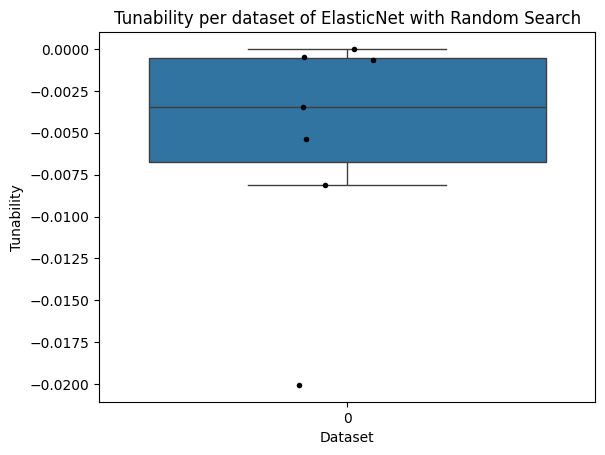

In [33]:
tunability_data = [tunability_per_dataset]

sns.boxplot(data=tunability_data, showfliers=False)

# add strip plot
sns.stripplot(data=tunability_data, color="black", size=4)

# add labels and title
plt.xlabel("Dataset")
plt.ylabel("Tunability")
plt.title("Tunability per dataset of ElasticNet with Random Search")

# show the plot
plt.show()

In [34]:
# aggregated tunability d
print(
    "Aggregated tunability d: "
    + str(calculate_aggregate_tunability(tunability_per_dataset))
)

Aggregated tunability d: -0.0054459181240627775


## Find best hyperparameters for given dataset with bayesian search


In [35]:
def get_bayes_search_space_elasticnet():
    return (
        {
            "model__alpha": Real(2 ** (-10), 2**10),
            "model__l1_ratio": Real(0.0, 1.0),
        },
        NUM_ITER_BAYES,
    )

In [36]:
np.int = np.int64  # hack so numpy doesn't complain about missing np.int :)
# calculate all configs
best_configs_for_elasticnet, histories = find_best_configs_in_search_space_with_bayes(
    search_space=get_bayes_search_space_elasticnet(),
    get_pipeline=get_elasticnet_pipeline,
    train_datasets=get_train_datasets(),
)
for i, history in enumerate(histories):
    dump_scores_to_csv(
        history, f"output_data/elasticnet/bayes_iteration_scores_dataset_{i}.csv"
    )

c:\JAN_CICHOMSKI\STUDIA\STUDIA_SEMESTR_7_2023_ZIMA\auto_ml\homeworks\homework_1\AutoML_HM1\.venv\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\JAN_CICHOMSKI\STUDIA\STUDIA_SEMESTR_7_2023_ZIMA\auto_ml\homeworks\homework_1\AutoML_HM1\.venv\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\JAN_CICHOMSKI\STUDIA\STUDIA_SEMESTR_7_2023_ZIMA\auto_ml\homeworks\homework_1\AutoML_HM1\.venv\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\JAN_CICHOMSKI\STUDIA\STUDIA_SEMESTR_7_2023_ZIMA\auto_ml\homeworks\homework_1\AutoML_HM1\.venv\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluate

Iteration 1: Score = -0.05320919309927983
Iteration 2: Score = -0.053206369835023845
Iteration 3: Score = -0.05320919309927983
Iteration 4: Score = -0.05320919309927983
Iteration 5: Score = -0.05320919309927983
Iteration 6: Score = -0.05320919309927983
Iteration 7: Score = -0.05280231042492813
Iteration 8: Score = -0.05320919309927983
Iteration 9: Score = -0.04839119175465312
Iteration 10: Score = -0.05320919309927983
Iteration 11: Score = 0.5762179596055417
Iteration 12: Score = -0.05320919309927983
Iteration 13: Score = 0.8397567738276465
Iteration 14: Score = 0.905113651019357
Iteration 15: Score = 0.905113651019357
Iteration 16: Score = -0.05320919309927983
Iteration 17: Score = 0.905113651019357
Iteration 18: Score = 0.905113651019357
Iteration 19: Score = 0.905113651019357
Iteration 20: Score = 0.905113651019357
Iteration 21: Score = 0.905113651019357
Iteration 22: Score = 0.905113651019357
Iteration 23: Score = 0.905113651019357
Iteration 24: Score = 0.905113651019357
Iteration 

c:\JAN_CICHOMSKI\STUDIA\STUDIA_SEMESTR_7_2023_ZIMA\auto_ml\homeworks\homework_1\AutoML_HM1\.venv\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\JAN_CICHOMSKI\STUDIA\STUDIA_SEMESTR_7_2023_ZIMA\auto_ml\homeworks\homework_1\AutoML_HM1\.venv\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\JAN_CICHOMSKI\STUDIA\STUDIA_SEMESTR_7_2023_ZIMA\auto_ml\homeworks\homework_1\AutoML_HM1\.venv\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\JAN_CICHOMSKI\STUDIA\STUDIA_SEMESTR_7_2023_ZIMA\auto_ml\homeworks\homework_1\AutoML_HM1\.venv\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluate

Iteration 1: Score = -0.0005240870054543211
Iteration 2: Score = -0.001293619083351949
Iteration 3: Score = -0.00012230865560605153
Iteration 4: Score = -0.00027298201790326715
Iteration 5: Score = 0.04314112454072574
Iteration 6: Score = 0.043334953035886525
Iteration 7: Score = -0.0015219467731020897
Iteration 8: Score = 0.011220851073546733
Iteration 9: Score = 0.0029993565504309538
Iteration 10: Score = -0.0008692043369627811
Iteration 11: Score = 0.5471243467786664
Iteration 12: Score = 0.7356084047290514
Iteration 13: Score = 0.9048563306610411
Iteration 14: Score = 0.9048563306610411
Iteration 15: Score = 0.9048563306610411
Iteration 16: Score = 0.9048595078756504
Iteration 17: Score = 0.05734442415519927
Iteration 18: Score = 0.9041005421511608
Iteration 19: Score = 0.8450113972449044
Iteration 20: Score = 0.9025684548826975
Iteration 21: Score = 0.9035953305551339
Iteration 22: Score = 0.24214263796360697
Iteration 23: Score = 0.8159294997113596
Iteration 24: Score = 0.9048589

c:\JAN_CICHOMSKI\STUDIA\STUDIA_SEMESTR_7_2023_ZIMA\auto_ml\homeworks\homework_1\AutoML_HM1\.venv\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\JAN_CICHOMSKI\STUDIA\STUDIA_SEMESTR_7_2023_ZIMA\auto_ml\homeworks\homework_1\AutoML_HM1\.venv\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\JAN_CICHOMSKI\STUDIA\STUDIA_SEMESTR_7_2023_ZIMA\auto_ml\homeworks\homework_1\AutoML_HM1\.venv\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\JAN_CICHOMSKI\STUDIA\STUDIA_SEMESTR_7_2023_ZIMA\auto_ml\homeworks\homework_1\AutoML_HM1\.venv\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluate

Iteration 1: Score = -0.030468644138217815
Iteration 2: Score = -0.030468644138217815
Iteration 3: Score = -0.030468644138217815
Iteration 4: Score = -0.030468644138217815
Iteration 5: Score = -0.030468644138217815
Iteration 6: Score = -0.030468644138217815
Iteration 7: Score = -0.030437012624651906
Iteration 8: Score = -0.030468644138217815
Iteration 9: Score = -0.030451655301209836
Iteration 10: Score = -0.030468644138217815
Iteration 11: Score = -0.030468644138217815
Iteration 12: Score = -0.030468644138217815
Iteration 13: Score = -0.030468644138217815
Iteration 14: Score = -0.030467531704311223
Iteration 15: Score = -0.030468644138217815
Iteration 16: Score = -0.030468644138217815
Iteration 17: Score = -0.029415345875184195
Iteration 18: Score = -0.030468644138217815
Iteration 19: Score = 0.45343038779106803
Iteration 20: Score = 0.4493817031984519
Iteration 21: Score = 0.45343038779106803
Iteration 22: Score = 0.45343038779106803
Iteration 23: Score = 0.45343038779106803
Iteratio

c:\JAN_CICHOMSKI\STUDIA\STUDIA_SEMESTR_7_2023_ZIMA\auto_ml\homeworks\homework_1\AutoML_HM1\.venv\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\JAN_CICHOMSKI\STUDIA\STUDIA_SEMESTR_7_2023_ZIMA\auto_ml\homeworks\homework_1\AutoML_HM1\.venv\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\JAN_CICHOMSKI\STUDIA\STUDIA_SEMESTR_7_2023_ZIMA\auto_ml\homeworks\homework_1\AutoML_HM1\.venv\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\JAN_CICHOMSKI\STUDIA\STUDIA_SEMESTR_7_2023_ZIMA\auto_ml\homeworks\homework_1\AutoML_HM1\.venv\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluate

Iteration 1: Score = -0.08448531463215266
Iteration 2: Score = -0.08534652856858727
Iteration 3: Score = -0.0844563506963016
Iteration 4: Score = -0.08458506165768909
Iteration 5: Score = -0.05146182099350845
Iteration 6: Score = -0.038865769911118654
Iteration 7: Score = -0.08553131813238361
Iteration 8: Score = -0.07377492322250663
Iteration 9: Score = -0.0823447989656034
Iteration 10: Score = -0.08441392272159427
Iteration 11: Score = 0.6112418588454713
Iteration 12: Score = 0.5986837145635617
Iteration 13: Score = 0.5289389513882534
Iteration 14: Score = 0.08376929405755602
Iteration 15: Score = -0.08508958455963009
Iteration 16: Score = 0.6224119916041501
Iteration 17: Score = -0.08528386039317852
Iteration 18: Score = 0.49278989227980025
Iteration 19: Score = -0.08407924972121969
Iteration 20: Score = 0.6224119916041501
Iteration 21: Score = 0.6224119916041501
Iteration 22: Score = 0.6224119916041501
Iteration 23: Score = 0.6224119916041501
Iteration 24: Score = 0.622411991604150

c:\JAN_CICHOMSKI\STUDIA\STUDIA_SEMESTR_7_2023_ZIMA\auto_ml\homeworks\homework_1\AutoML_HM1\.venv\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\JAN_CICHOMSKI\STUDIA\STUDIA_SEMESTR_7_2023_ZIMA\auto_ml\homeworks\homework_1\AutoML_HM1\.venv\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\JAN_CICHOMSKI\STUDIA\STUDIA_SEMESTR_7_2023_ZIMA\auto_ml\homeworks\homework_1\AutoML_HM1\.venv\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\JAN_CICHOMSKI\STUDIA\STUDIA_SEMESTR_7_2023_ZIMA\auto_ml\homeworks\homework_1\AutoML_HM1\.venv\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluate

Iteration 1: Score = -0.04783734841928187
Iteration 2: Score = -0.04783734841928187
Iteration 3: Score = -0.04783734841928187
Iteration 4: Score = -0.04783734841928187
Iteration 5: Score = -0.04783734841928187
Iteration 6: Score = -0.04783734841928187
Iteration 7: Score = -0.04783734841928187
Iteration 8: Score = -0.04783734841928187
Iteration 9: Score = -0.04783734841928187
Iteration 10: Score = -0.04783734841928187
Iteration 11: Score = -0.04783734841928187
Iteration 12: Score = -0.04783734841928187
Iteration 13: Score = 0.5107067070951802
Iteration 14: Score = -0.04783734841928187
Iteration 15: Score = -0.040482627227401854
Iteration 16: Score = -0.04783734841928187
Iteration 17: Score = 0.5107067070951802
Iteration 18: Score = 0.5169495900300881
Iteration 19: Score = 0.5169495900300881
Iteration 20: Score = -0.04783734841928187
Iteration 21: Score = 0.5169495900300881
Iteration 22: Score = 0.5169495900300881
Iteration 23: Score = 0.5169495900300881
Iteration 24: Score = -0.04783734

c:\JAN_CICHOMSKI\STUDIA\STUDIA_SEMESTR_7_2023_ZIMA\auto_ml\homeworks\homework_1\AutoML_HM1\.venv\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\JAN_CICHOMSKI\STUDIA\STUDIA_SEMESTR_7_2023_ZIMA\auto_ml\homeworks\homework_1\AutoML_HM1\.venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.883e+03, tolerance: 3.510e+00 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


Iteration 1: Score = -0.007952659633162319
Iteration 2: Score = -0.007952659633162319
Iteration 3: Score = -0.007952659633162319
Iteration 4: Score = -0.007952659633162319
Iteration 5: Score = -0.007952659633162319
Iteration 6: Score = -0.007952659633162319
Iteration 7: Score = -0.007952659633162319
Iteration 8: Score = -0.007952659633162319
Iteration 9: Score = -0.007952659633162319
Iteration 10: Score = -0.007952659633162319
Iteration 11: Score = -0.007952659633162319
Iteration 12: Score = -0.007952659633162319
Iteration 13: Score = -0.007952659633162319
Iteration 14: Score = -0.007952659633162319
Iteration 15: Score = -0.007952659633162319
Iteration 16: Score = -0.007952659633162319
Iteration 17: Score = 0.09096852048577617
Iteration 18: Score = 0.0018457105661228602
Iteration 19: Score = 0.7121229943426186
Iteration 20: Score = 0.7120160124296315
Iteration 21: Score = 0.06352219049400179
Iteration 22: Score = 0.7121096418789501
Iteration 23: Score = 0.7121229943426186
Iteration 24:

c:\JAN_CICHOMSKI\STUDIA\STUDIA_SEMESTR_7_2023_ZIMA\auto_ml\homeworks\homework_1\AutoML_HM1\.venv\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\JAN_CICHOMSKI\STUDIA\STUDIA_SEMESTR_7_2023_ZIMA\auto_ml\homeworks\homework_1\AutoML_HM1\.venv\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\JAN_CICHOMSKI\STUDIA\STUDIA_SEMESTR_7_2023_ZIMA\auto_ml\homeworks\homework_1\AutoML_HM1\.venv\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\JAN_CICHOMSKI\STUDIA\STUDIA_SEMESTR_7_2023_ZIMA\auto_ml\homeworks\homework_1\AutoML_HM1\.venv\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluate

Iteration 1: Score = -0.0028718766188328805
Iteration 2: Score = -0.0028718766188328805
Iteration 3: Score = -0.0028718766188328805
Iteration 4: Score = -0.0028718766188328805
Iteration 5: Score = -0.0028718766188328805
Iteration 6: Score = -0.0028718766188328805
Iteration 7: Score = -0.0028718766188328805
Iteration 8: Score = -0.0028718766188328805
Iteration 9: Score = -0.0028718766188328805
Iteration 10: Score = -0.0028718766188328805
Iteration 11: Score = -0.0028718766188328805
Iteration 12: Score = 0.9939682059870357
Iteration 13: Score = 0.41412541191175745
Iteration 14: Score = -0.0028718766188328805
Iteration 15: Score = 0.9939772127881927
Iteration 16: Score = 0.002088895646502431
Iteration 17: Score = 0.09018227364338686
Iteration 18: Score = 0.9939726364992477
Iteration 19: Score = 0.9939726490224878
Iteration 20: Score = -0.0028718766188328805
Iteration 21: Score = 0.4405732442567444
Iteration 22: Score = 0.9939682059870357
Iteration 23: Score = 0.9950214740972049
Iteration 

### Plot bayes optimization history for each dataset

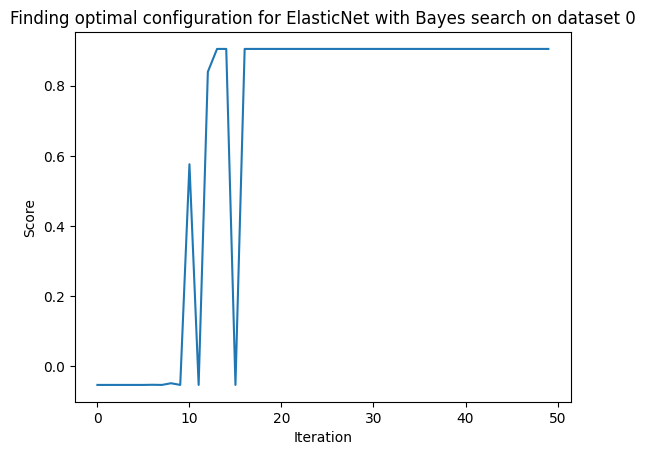

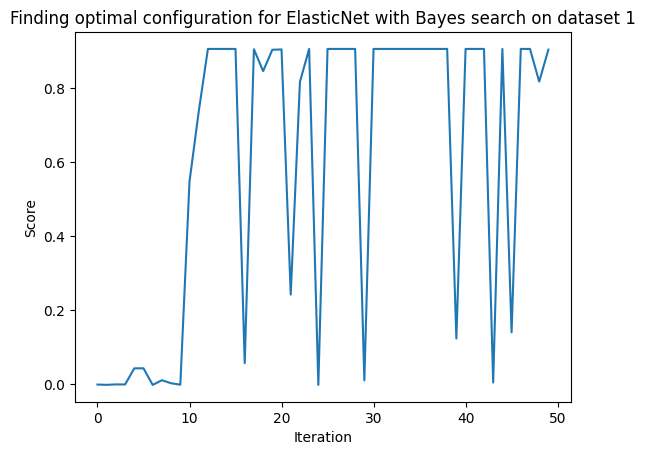

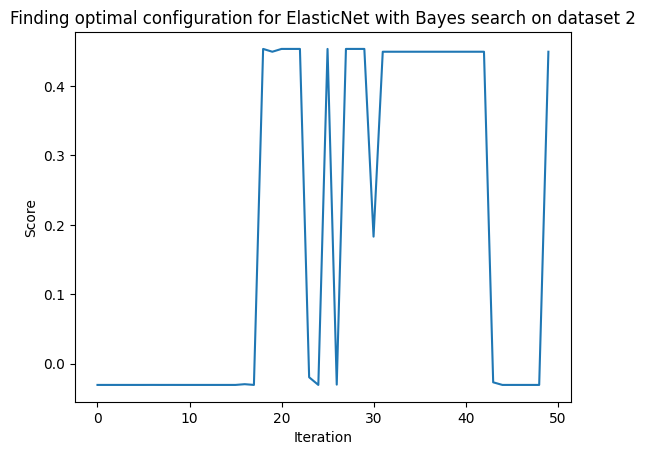

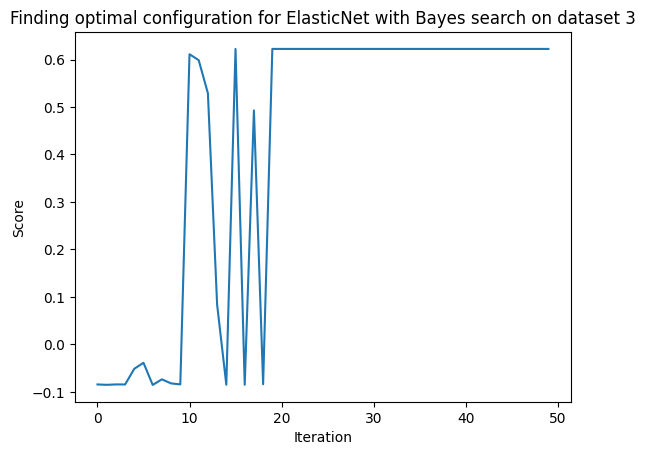

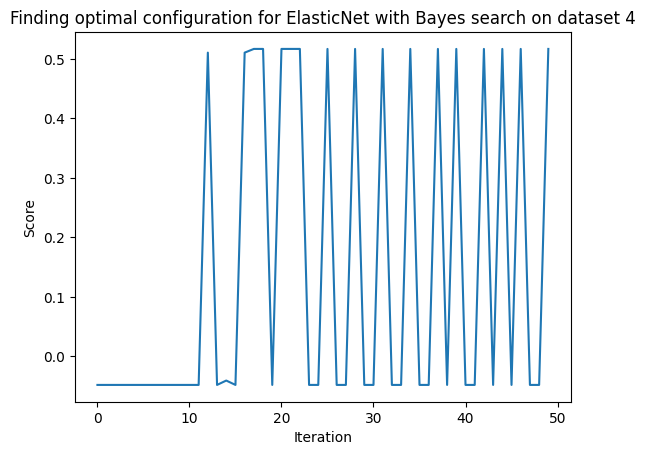

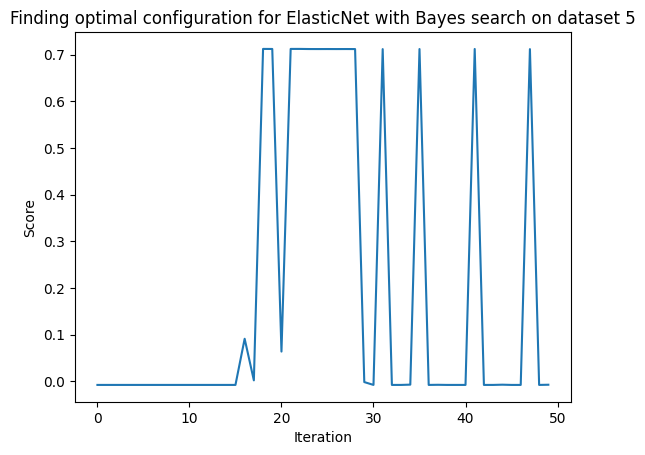

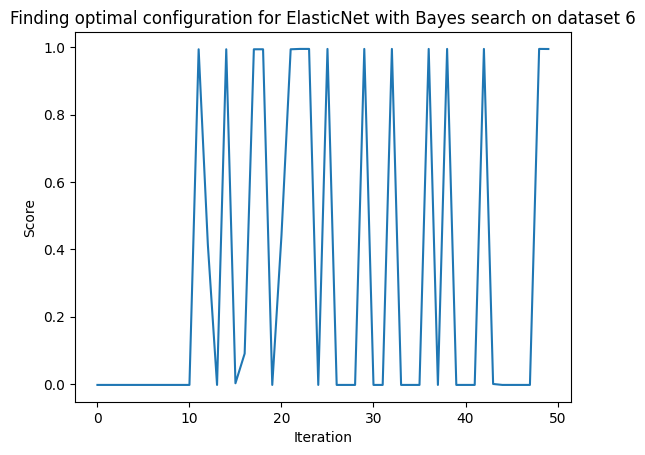

In [37]:
for i in range(len(histories)):
    plt.plot(histories[i])
    plt.xlabel("Iteration")
    plt.ylabel("Score")
    plt.title(
        f"Finding optimal configuration for ElasticNet with Bayes search on dataset {i}"
    )
    plt.show()

## Calculate tunability on each dataset

In [38]:
tunability_per_dataset = calculate_tunability_on_each_dataset(
    train_datasets=get_train_datasets(),
    test_datasets=get_test_datasets(),
    best_configs=best_configs_for_elasticnet,
    optimal_config=optimal_config_elasticnet,
    get_model_pipeline=get_elasticnet_pipeline,
)
dump_tunability_to_csv(
    tunability_per_dataset=tunability_per_dataset,
    filepath="output_data/elasticnet/bayes_tunability.csv",
)

c:\JAN_CICHOMSKI\STUDIA\STUDIA_SEMESTR_7_2023_ZIMA\auto_ml\homeworks\homework_1\AutoML_HM1\.venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.154e+03, tolerance: 1.561e+03
  model = cd_fast.enet_coordinate_descent(


d^j: 0.9493198373500374 - 0.9505601623165735 = -0.0012403249665360327
d^j: 0.9234301066751305 - 0.9235184103671745 = -8.830369204404498e-05
d^j: 0.4562601389486769 - 0.4568785360227773 = -0.0006183970741003852


c:\JAN_CICHOMSKI\STUDIA\STUDIA_SEMESTR_7_2023_ZIMA\auto_ml\homeworks\homework_1\AutoML_HM1\.venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.182e+05, tolerance: 2.145e+02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


d^j: 0.5380720957277267 - 0.5282416821372122 = 0.009830413590514508
d^j: 0.5601648526717664 - 0.5640687658797898 = -0.003903913208023413
d^j: 0.6359803184465578 - 0.6382684740785797 = -0.002288155632021893
d^j: 0.992060967254481 - 0.9928203996602365 = -0.0007594324057554891


c:\JAN_CICHOMSKI\STUDIA\STUDIA_SEMESTR_7_2023_ZIMA\auto_ml\homeworks\homework_1\AutoML_HM1\.venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.883e+03, tolerance: 3.510e+00 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


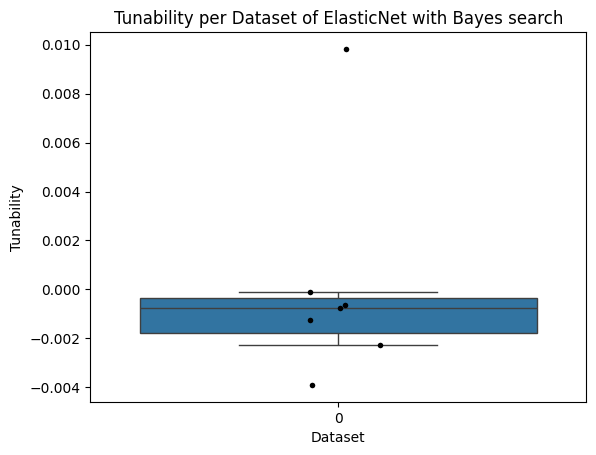

In [39]:
tunability_data = [tunability_per_dataset]

sns.boxplot(data=tunability_data, showfliers=False)

# add strip plot
sns.stripplot(data=tunability_data, color="black", size=4)

# add labels and title
plt.xlabel("Dataset")
plt.ylabel("Tunability")
plt.title("Tunability per Dataset of ElasticNet with Bayes search")

# show the plot
plt.show()

In [40]:
# aggregated tunability d
print(
    "Aggregated tunability d: "
    + str(calculate_aggregate_tunability(tunability_per_dataset))
)

Aggregated tunability d: 0.0001331266588618929


# 3. Random Forest

## Prepare model and search space

In [41]:
def get_random_forest_pipeline():
    random_forest = RandomForestRegressor(bootstrap=True, random_state=SEED)
    col_trans: ColumnTransformer = get_column_transformer()
    random_forest_pipeline = Pipeline(
        steps=[("column_transformer", col_trans), ("model", random_forest)]
    )
    return random_forest_pipeline

In [42]:
def get_parameter_grid_for_random_forest():
    # parameters space
    random.seed(SEED)
    # max_depth_values = range(1, 31, 1)
    min_samples_split_values = range(2, 528, 5)
    min_samples_leaf_values = range(1, 10, 1)
    n_estimators_values = range(1, 2000, 10)
    max_samples_values = [float(i) * 0.1 for i in range(1, 11, 1)]
    max_features_values = [i for i in range(1, 15, 1)]
    all_combinations = list(
        itertools.product(
            # max_depth_values,
            min_samples_split_values,
            min_samples_leaf_values,
            n_estimators_values,
            max_samples_values,
            max_features_values,
        )
    )
    selected_combinations: List[Tuple[float, int, int, int]] = random.sample(
        all_combinations, NUM_POINTS_RS_RANDOM_FOREST
    )
    parameter_names = [
        # "model__max_depth",
        "model__min_samples_split",
        "model__min_samples_leaf",
        "model__n_estimators",
        "model__max_samples",
        "model__max_features",
    ]

    parameters_grid_random_forest = [
        dict(zip(parameter_names, combination)) for combination in selected_combinations
    ]
    return parameters_grid_random_forest

## Find optimal default hyperparameters 

In [43]:
(
    optimal_config_random_forest,
    best_summary_score_random_forest,
    history_scores,
) = find_optimal_configuration_for_all_datasets(
    config_space=get_parameter_grid_for_random_forest(),
    train_datasets=get_train_datasets(),
    test_datasets=get_test_datasets(),
    get_model=get_random_forest_pipeline,
    summary_func=np.mean,  # Or np.median for a more robust approach
)
dump_optimal_config_search_history(
    history_scores, "output_data/random_forest/optimal_config_search_history.csv"
)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


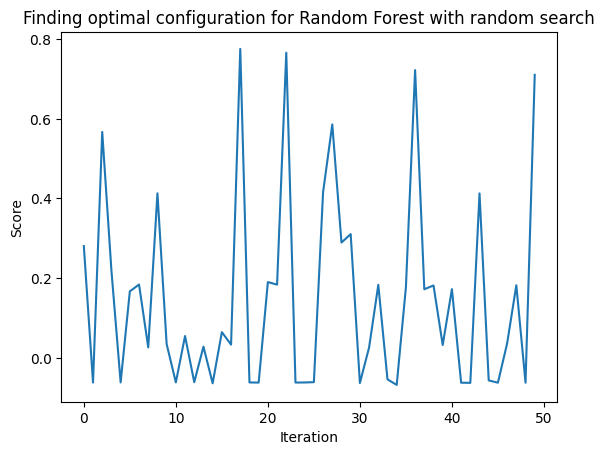

In [44]:
plt.plot(history_scores)
plt.xlabel("Iteration")
plt.ylabel("Score")
plt.title("Finding optimal configuration for Random Forest with random search")
plt.show()

In [45]:
print(optimal_config_random_forest)
print(best_summary_score_random_forest)

{'model__min_samples_split': 12, 'model__min_samples_leaf': 1, 'model__n_estimators': 211, 'model__max_samples': 0.7000000000000001, 'model__max_features': 9}
0.7753437913134225


## Evaluate model with optimal hyperparameters on each dataset

In [46]:
for train_dataset, test_dataset in zip(get_train_datasets(), get_test_datasets()):
    optimal_model: Pipeline = get_random_forest_pipeline()
    optimal_model.set_params(**optimal_config_random_forest)
    optimal_model.fit(train_dataset[0], train_dataset[1])
    score = optimal_model.score(test_dataset[0], test_dataset[1])
    print("Optimal random_forest score on dataset : " + str(score))

Optimal random_forest score on dataset : 0.9586079386155052
Optimal random_forest score on dataset : 0.9481960981165232
Optimal random_forest score on dataset : 0.46304254785251375
Optimal random_forest score on dataset : 0.6285761798122983
Optimal random_forest score on dataset : 0.5792721612055236
Optimal random_forest score on dataset : 0.8587464370562763
Optimal random_forest score on dataset : 0.9909651765353168


## Find best hyperparameters for given dataset with random search

In [47]:
# find tate^(j)*
(
    best_random_forest_configs_for_each_dataset,
    list_iteration_scores,
) = find_best_configs_in_search_space_with_random_search(
    get_pipeline=get_random_forest_pipeline,
    config_space=get_parameter_grid_for_random_forest(),
    train_datasets=get_train_datasets(),
    test_datasets=get_test_datasets(),
)
for i, iteration_scores in enumerate(list_iteration_scores):
    dump_scores_to_csv(
        iteration_scores,
        f"output_data/random_forest/random_search_iteration_scores_dataset_{i}.csv",
    )

dataset: 0
score: 0.9586079386155052
best config: {'model__min_samples_split': 12, 'model__min_samples_leaf': 1, 'model__n_estimators': 211, 'model__max_samples': 0.7000000000000001, 'model__max_features': 9}
dataset: 1
score: 0.9481960981165232
best config: {'model__min_samples_split': 12, 'model__min_samples_leaf': 1, 'model__n_estimators': 211, 'model__max_samples': 0.7000000000000001, 'model__max_features': 9}
dataset: 2
score: 0.48170954202192096
best config: {'model__min_samples_split': 22, 'model__min_samples_leaf': 3, 'model__n_estimators': 1311, 'model__max_samples': 0.6000000000000001, 'model__max_features': 12}
dataset: 3
score: 0.6566797960122495
best config: {'model__min_samples_split': 22, 'model__min_samples_leaf': 3, 'model__n_estimators': 1311, 'model__max_samples': 0.6000000000000001, 'model__max_features': 12}
dataset: 4
score: 0.596695354602693
best config: {'model__min_samples_split': 22, 'model__min_samples_leaf': 3, 'model__n_estimators': 1311, 'model__max_sample

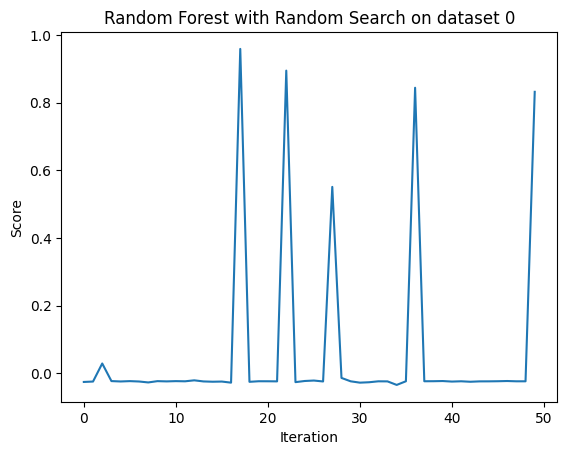

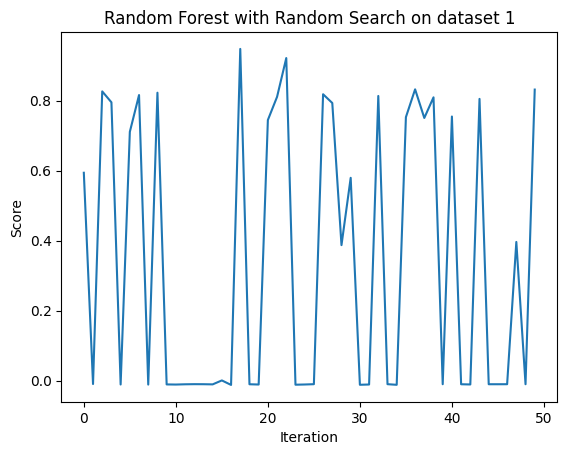

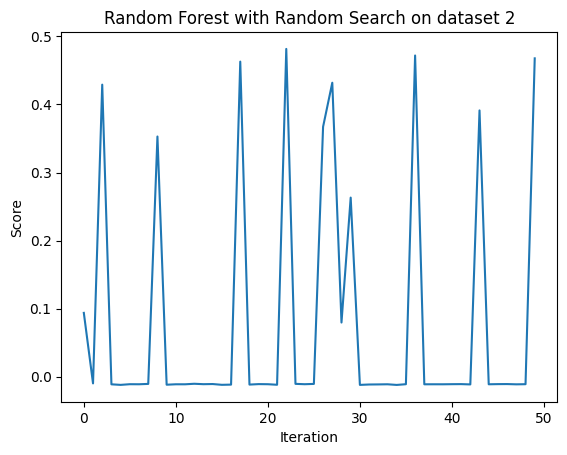

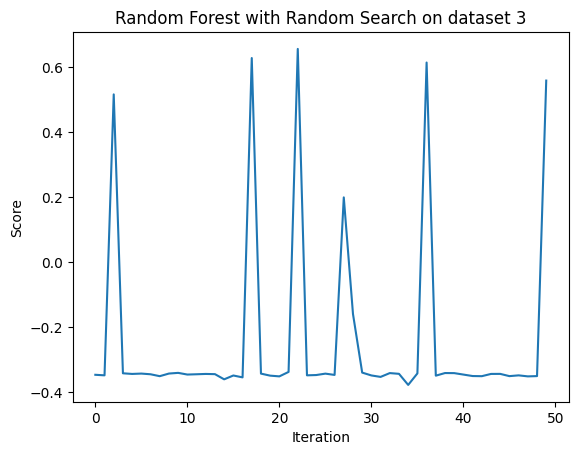

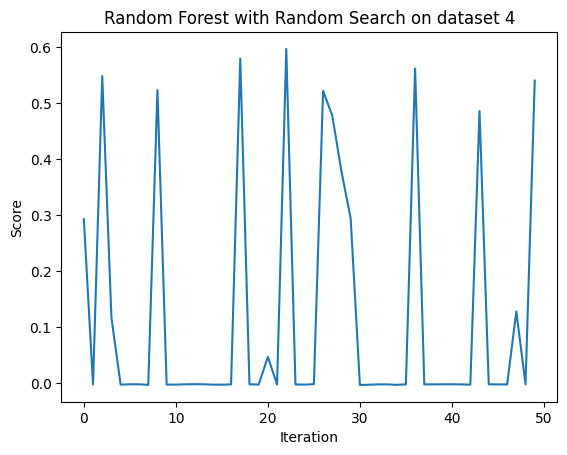

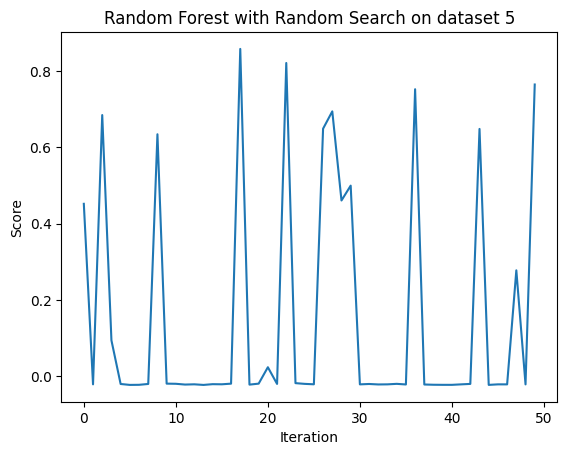

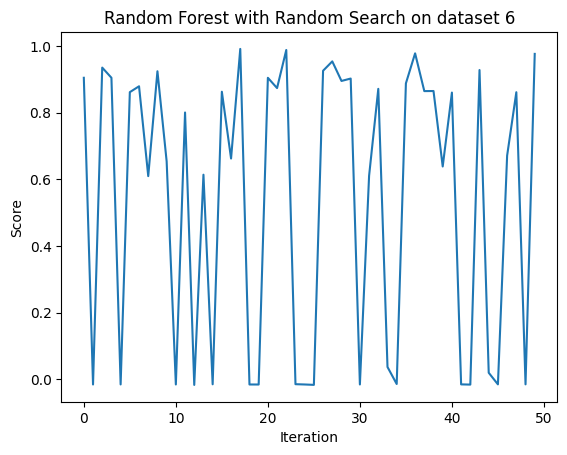

In [48]:
for i, iteration_scores in enumerate(list_iteration_scores):
    plt.plot(iteration_scores)
    plt.xlabel("Iteration")
    plt.ylabel("Score")
    plt.title(f"Random Forest with Random Search on dataset {i}")
    plt.show()

## Calculate tunability on each dataset

In [49]:
# find d^j

tunability_per_dataset = calculate_tunability_on_each_dataset(
    train_datasets=get_train_datasets(),
    test_datasets=get_test_datasets(),
    best_configs=best_random_forest_configs_for_each_dataset,
    optimal_config=optimal_config_random_forest,
    get_model_pipeline=get_random_forest_pipeline,
)
dump_tunability_to_csv(
    tunability_per_dataset=tunability_per_dataset,
    filepath="output_data/random_forest/random_search_tunability.csv",
)

d^j: 0.9586079386155052 - 0.9586079386155052 = 0.0
d^j: 0.9481960981165232 - 0.9481960981165232 = 0.0
d^j: 0.46304254785251375 - 0.48170954202192096 = -0.018666994169407203
d^j: 0.6285761798122983 - 0.6566797960122495 = -0.028103616199951165
d^j: 0.5792721612055236 - 0.596695354602693 = -0.017423193397169356
d^j: 0.8587464370562763 - 0.8587464370562763 = 0.0
d^j: 0.9909651765353168 - 0.9909651765353168 = 0.0


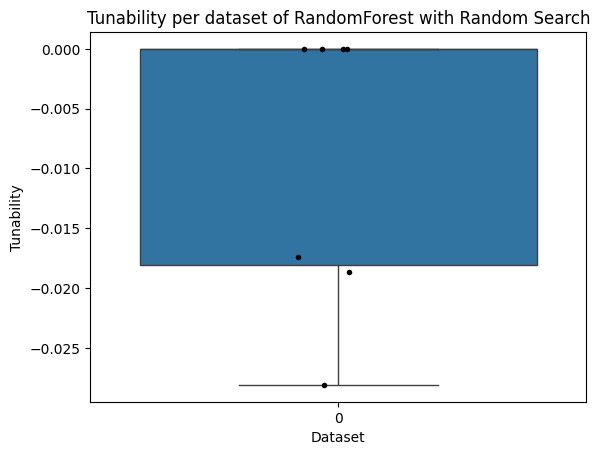

In [50]:
tunability_data = [tunability_per_dataset]

sns.boxplot(data=tunability_data, showfliers=False)

# add strip plot
sns.stripplot(data=tunability_data, color="black", size=4)

# add labels and title
plt.xlabel("Dataset")
plt.ylabel("Tunability")
plt.title("Tunability per dataset of RandomForest with Random Search")

# show the plot
plt.show()

In [51]:
# aggregated tunability d
print(
    "Aggregated tunability d: "
    + str(calculate_aggregate_tunability(tunability_per_dataset))
)

Aggregated tunability d: -0.009170543395218247


## Find best hyperparameters for given dataset with bayesian search


In [52]:
def get_bayes_search_space_random_forest():
    return (
        {
            "model__min_samples_split": Integer(2, 528),
            "model__min_samples_leaf": Integer(2, 10),
            "model__min_samples_leaf": Integer(1, 60),
            "model__n_estimators": Integer(1, 2000),
            "model__max_samples": Real(0.1, 1.0),
            "model__max_features": Integer(1, 14),
        },
        NUM_ITER_BAYES,
    )

In [53]:
np.int = np.int64  # hack so numpy doesn't complain about missing np.int :)
# calculate all configs
(
    best_configs_for_random_forest,
    histories,
) = find_best_configs_in_search_space_with_bayes(
    search_space=get_bayes_search_space_random_forest(),
    get_pipeline=get_random_forest_pipeline,
    train_datasets=get_train_datasets(),
)
for i, history in enumerate(histories):
    dump_scores_to_csv(
        history, f"output_data/random_forest/bayes_iteration_scores_dataset_{i}.csv"
    )

c:\JAN_CICHOMSKI\STUDIA\STUDIA_SEMESTR_7_2023_ZIMA\auto_ml\homeworks\homework_1\AutoML_HM1\.venv\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration 1: Score = -0.052417703796859526
Iteration 2: Score = -0.05123375274240534
Iteration 3: Score = -0.05209468669585404
Iteration 4: Score = -0.05218813231178743
Iteration 5: Score = -0.053203284532385764
Iteration 6: Score = -0.053225245630862214
Iteration 7: Score = -0.05311586927157719
Iteration 8: Score = -0.05263564051831926
Iteration 9: Score = -0.05140202295086791
Iteration 10: Score = -0.052613064640754416
Iteration 11: Score = -0.050364827852576746
Iteration 12: Score = -0.052507913135234174
Iteration 13: Score = -0.05283605146285084
Iteration 14: Score = -0.04874853247655091
Iteration 15: Score = -0.05284574762836654
Iteration 16: Score = 0.8929961759545542
Iteration 17: Score = 0.5854621981560255
Iteration 18: Score = -0.05342733471207013
Iteration 19: Score = 0.861324723347822
Iteration 20: Score = 0.8608599431175934
Iteration 21: Score = 0.9094113275795408
Iteration 22: Score = 0.9242285738120974
Iteration 23: Score = 0.935576788381103
Iteration 24: Score = 0.946024

### Plot bayes optimization history for each dataset

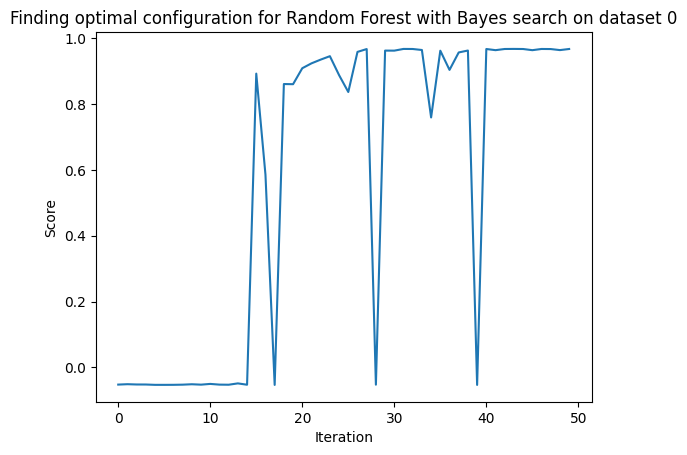

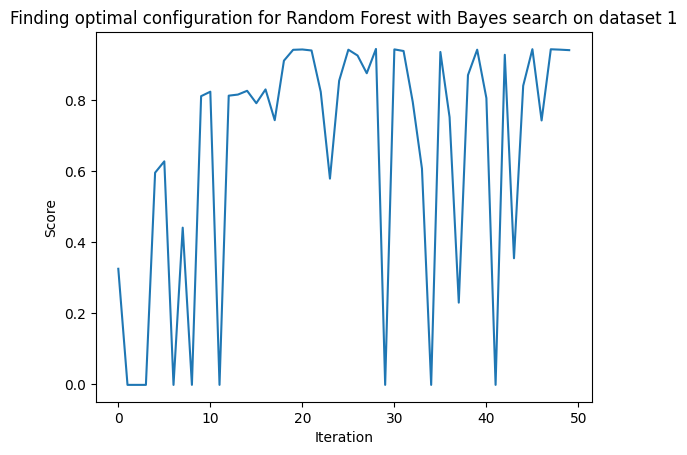

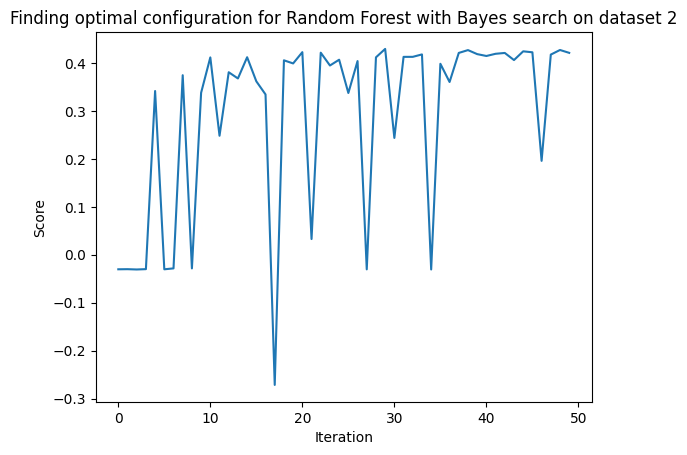

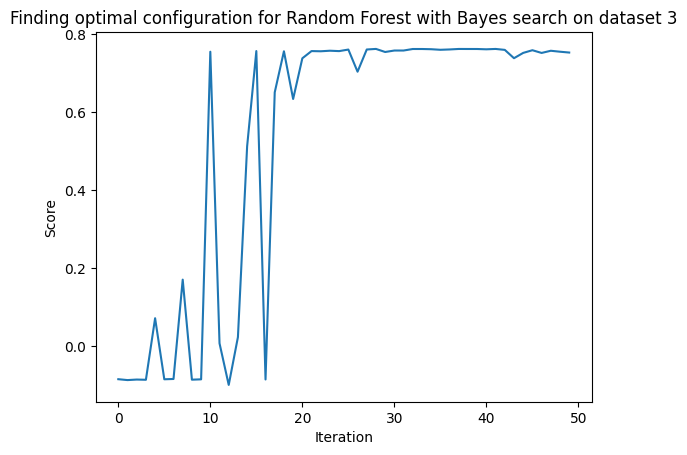

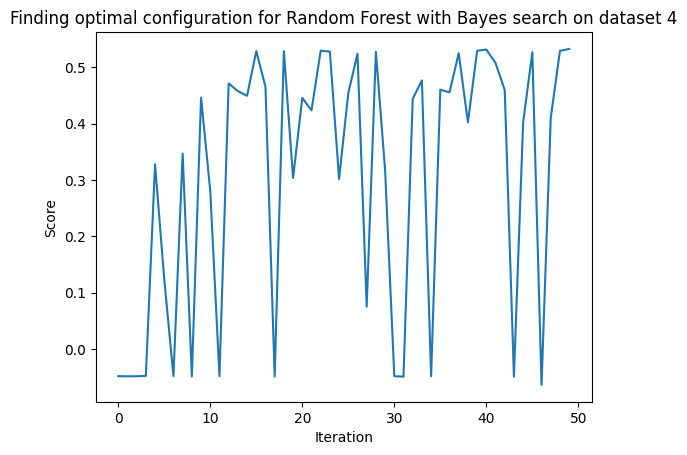

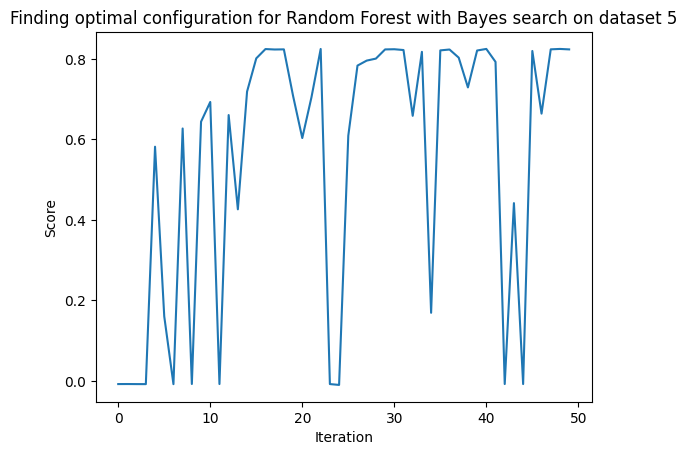

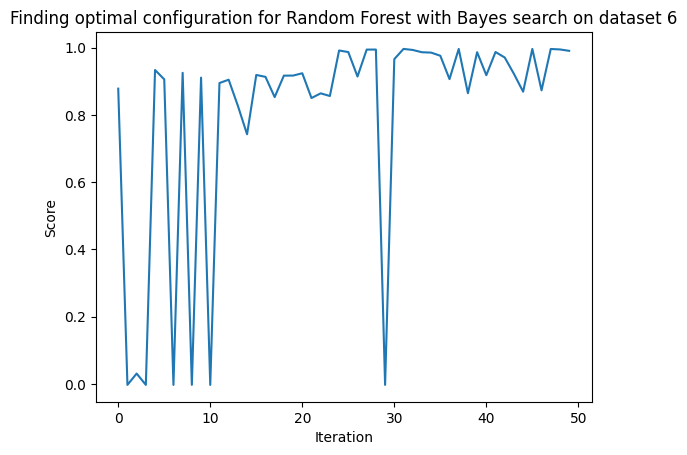

In [54]:
for i in range(len(histories)):
    plt.plot(histories[i])
    plt.xlabel("Iteration")
    plt.ylabel("Score")
    plt.title(
        f"Finding optimal configuration for Random Forest with Bayes search on dataset {i}"
    )
    plt.show()

## Calculate tunability on each dataset

In [55]:
tunability_per_dataset = calculate_tunability_on_each_dataset(
    train_datasets=get_train_datasets(),
    test_datasets=get_test_datasets(),
    best_configs=best_configs_for_random_forest,
    optimal_config=optimal_config_random_forest,
    get_model_pipeline=get_random_forest_pipeline,
)
dump_tunability_to_csv(
    tunability_per_dataset=tunability_per_dataset,
    filepath="output_data/random_forest/bayes_tunability.csv",
)

d^j: 0.9586079386155052 - 0.9716528733505123 = -0.013044934735007119
d^j: 0.9481960981165232 - 0.9587600372997978 = -0.010563939183274584
d^j: 0.46304254785251375 - 0.4825438619781355 = -0.019501314125621727
d^j: 0.6285761798122983 - 0.6888341705635666 = -0.06025799075126825
d^j: 0.5792721612055236 - 0.6026416229750435 = -0.023369461769519928
d^j: 0.8587464370562763 - 0.8787162339599709 = -0.019969796903694603
d^j: 0.9909651765353168 - 0.9921500506903856 = -0.001184874155068849


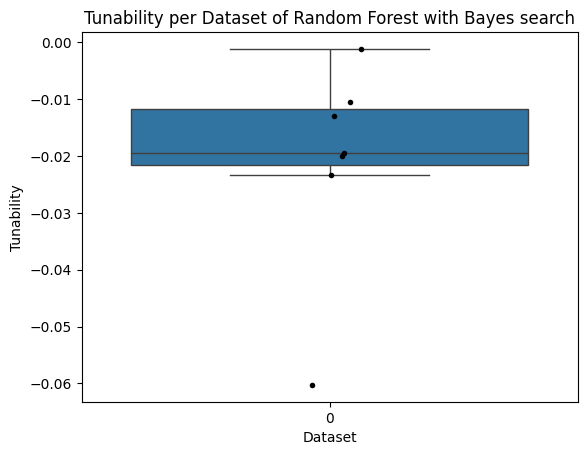

In [56]:
tunability_data = [tunability_per_dataset]

sns.boxplot(data=tunability_data, showfliers=False)

# add strip plot
sns.stripplot(data=tunability_data, color="black", size=4)

# add labels and title
plt.xlabel("Dataset")
plt.ylabel("Tunability")
plt.title("Tunability per Dataset of Random Forest with Bayes search")

# show the plot
plt.show()

In [57]:
# aggregated tunability d
print(
    "Aggregated tunability d: "
    + str(calculate_aggregate_tunability(tunability_per_dataset))
)

Aggregated tunability d: -0.02112747308906501
